In [1]:
import sys
sys.path.append('/Users/gregmartinez/.local/share/virtualenvs/mtg_scraper-N8QFuhGA/lib/python3.8/site-packages/')

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom_test, ttest_1samp, chi2_contingency, ttest_ind, f_oneway
from matplotlib.backends.backend_pdf import PdfPages
import re
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.corpus import wordnet

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)

In [4]:
FLAT_FILE_DIR = "../flat_files/"

full_table = pd.read_csv(FLAT_FILE_DIR + "full_table.csv")
event_table = pd.read_csv(FLAT_FILE_DIR + "event_table.csv")
deck_list_table = pd.read_csv(FLAT_FILE_DIR + "deck_list_table.csv")
pilot_table = pd.read_csv(FLAT_FILE_DIR + "pilot_table.csv")
deck_table = pd.read_csv(FLAT_FILE_DIR + "deck_table.csv")
card_table = pd.read_csv(FLAT_FILE_DIR + "card_table.csv")

event_table["date"] = pd.to_datetime(event_table["date"])
full_table["date"] = pd.to_datetime(full_table["date"])
deck_table["rank"] = pd.to_numeric(deck_table["rank"])

In [5]:
deck_table.tail(25)

deckId  eventId  pilotId                 deckUrl  \
3111    3112      596     1869  ?e=29204&d=429837&f=ST   
3112    3113      597      355  ?e=29205&d=429840&f=ST   
3113    3114      597      600  ?e=29205&d=429841&f=ST   
3114    3115      597      743  ?e=29205&d=429842&f=ST   
3115    3116      597     1870  ?e=29205&d=429843&f=ST   
3116    3117      597     1871  ?e=29205&d=429845&f=ST   
3117    3118      597     1872  ?e=29205&d=429847&f=ST   
3118    3119      597     1873  ?e=29205&d=429844&f=ST   
3119    3120      597     1874  ?e=29205&d=429846&f=ST   
3120    3121      598      893  ?e=29206&d=429856&f=ST   
3121    3122      598      166  ?e=29206&d=429857&f=ST   
3122    3123      598     1875  ?e=29206&d=429858&f=ST   
3123    3124      598      160  ?e=29206&d=429859&f=ST   
3124    3125      598      618  ?e=29206&d=429862&f=ST   
3125    3126      598     1217  ?e=29206&d=429863&f=ST   
3126    3127      598      602  ?e=29206&d=429860&f=ST   
3127    3128      598      159  ?e=29206&d=429861&f=ST   
3128    3129      599     1876  ?e=29207&d=429864&f=ST   
3129    3130      599      571  ?e=29207&d=429865&f=ST   
3130    3131      599      157  ?e=29207&d=429867&f=ST   
3131    3132      599     1054  ?e=29207&d=429866&f=ST   
3132    3133      599     1043  ?e=29207&d=429868&f=ST   
3133    3134      599      352  ?e=29207&d=429869&f=ST   
3134    3135      599     1877  ?e=29207&d=429870&f=ST   
3135    3136      599      110  ?e=29207&d=429871&f=ST   

                         name  rank archetype    category  
3111  Sultai Yorion Ultimatum     5      ramp      sultai  
3112        Mono Blue Control     1   control   mono blue  
3113  Sultai Yorion Ultimatum     2      ramp      sultai  
3114              Gruul Aggro     3     aggro       gruul  
3115            Izzet Control     3   control       izzet  
3116      Boros Cycling Aggro     5   cycling       boros  
3117      Boros Cycling Aggro     5   cycling       boros  
3118  Sultai Yorion Ultimatum     5      ramp      sultai  
3119  Sultai Yorion Ultimatum     5      ramp      sultai  
3120  Sultai Yorion Ultimatum     1      ramp      sultai  
3121            Izzet Control     2   control       izzet  
3122               Naya Aggro     3     aggro        naya  
3123  Sultai Yorion Ultimatum     3      ramp      sultai  
3124               Dimir Mill     5      mill       dimir  
3125           Sultai Control     5   control      sultai  
3126  Sultai Yorion Ultimatum     5      ramp      sultai  
3127  Sultai Yorion Ultimatum     5      ramp      sultai  
3128  Sultai Yorion Ultimatum     1      ramp      sultai  
3129  Sultai Yorion Ultimatum     2      ramp      sultai  
3130               Dimir Mill     3      mill       dimir  
3131             Weenie White     3     aggro  mono white  
3132              Gruul Aggro     5     aggro       gruul  
3133              Gruul Aggro     5     aggro       gruul  
3134            Red Deck Wins     5     aggro    mono red  
3135            Sultai Yorion     5   control      sultai

In [6]:
event_table.tail(25)

eventId                                                           name  \
574      575                                          Event @ Lotus eSports   
575      576  Europe Central Mock Tournament #1 - Flight A @ Judge Learning   
576      577                             Gentry ! @ The Gentry Magic League   
577      578                          Event @ Taverna Geek (Santos, Brasil)   
578      579                                        MTGO Standard Challenge   
579      580               Octagon Event @ Dice City Games & Team Lotus Box   
580      581                           Free Daily - Bo1 @ Owl Central Games   
581      582                                      Event @ The Monkey Planet   
582      583                                    Final Qualifier @ BIG Magic   
583      584                                            Grinch Melee @ MTGA   
584      585                                           MTGO Standard League   
585      586               SCG Tour Online - Satellite #3 @ Star City Games   
586      587               SCG Tour Online - Satellite #4 @ Star City Games   
587      588                                      Event @ The Monkey Planet   
588      589                                       Event @ Gamer's Gauntlet   
589      590               SCG Tour Online - Satellite #1 @ Star City Games   
590      591               SCG Tour Online - Satellite #2 @ Star City Games   
591      592                             FNM at Home @ Draagoons Hobby Shop   
592      593                                            FNM @ Lotus eSports   
593      594                                        Event @ On Curve Events   
594      595                                       Championship @ Masonetis   
595      596               SCG Tour Online - Satellite #5 @ Star City Games   
596      597               SCG Tour Online - Satellite #6 @ Star City Games   
597      598                      Japan Championship 2020 Final @ BIG Magic   
598      599               United Valentine Invitational @ F2K (Fade2Karma)   

                                           link       date latest_set  
574  https://www.mtgtop8.com/event?e=29148&f=ST 2021-02-09   Kaldheim  
575  https://www.mtgtop8.com/event?e=29150&f=ST 2021-02-06   Kaldheim  
576  https://www.mtgtop8.com/event?e=29154&f=ST 2021-02-09   Kaldheim  
577  https://www.mtgtop8.com/event?e=29157&f=ST 2021-02-09   Kaldheim  
578  https://www.mtgtop8.com/event?e=29156&f=ST 2021-02-08   Kaldheim  
579  https://www.mtgtop8.com/event?e=29160&f=ST 2021-02-10   Kaldheim  
580  https://www.mtgtop8.com/event?e=29161&f=ST 2021-02-10   Kaldheim  
581  https://www.mtgtop8.com/event?e=29168&f=ST 2021-02-11   Kaldheim  
582  https://www.mtgtop8.com/event?e=29173&f=ST 2021-02-11   Kaldheim  
583  https://www.mtgtop8.com/event?e=29167&f=ST 2021-02-10   Kaldheim  
584  https://www.mtgtop8.com/event?e=29174&f=ST 2021-02-08   Kaldheim  
585  https://www.mtgtop8.com/event?e=29181&f=ST 2021-02-13   Kaldheim  
586  https://www.mtgtop8.com/event?e=29182&f=ST 2021-02-13   Kaldheim  
587  https://www.mtgtop8.com/event?e=29193&f=ST 2021-02-13   Kaldheim  
588  https://www.mtgtop8.com/event?e=29194&f=ST 2021-02-13   Kaldheim  
589  https://www.mtgtop8.com/event?e=29179&f=ST 2021-02-12   Kaldheim  
590  https://www.mtgtop8.com/event?e=29180&f=ST 2021-02-12   Kaldheim  
591  https://www.mtgtop8.com/event?e=29183&f=ST 2021-02-12   Kaldheim  
592  https://www.mtgtop8.com/event?e=29191&f=ST 2021-02-12   Kaldheim  
593  https://www.mtgtop8.com/event?e=29192&f=ST 2021-02-12   Kaldheim  
594  https://www.mtgtop8.com/event?e=29203&f=ST 2021-02-13   Kaldheim  
595  https://www.mtgtop8.com/event?e=29204&f=ST 2021-02-13   Kaldheim  
596  https://www.mtgtop8.com/event?e=29205&f=ST 2021-02-13   Kaldheim  
597  https://www.mtgtop8.com/event?e=29206&f=ST 2021-02-13   Kaldheim  
598  https://www.mtgtop8.com/event?e=29207&f=ST 2021-02-13   Kaldheim

In [7]:
# Common Slices
illegal_decks = full_table[
    ~full_table["cardId"].isin(card_table[card_table["standardLegality"] == "legal"]["cardId"])
]["deckId"]

first_place_decks = deck_table[
    (deck_table["rank"] == 1)
    & ~(deck_table["deckId"].isin(illegal_decks))
].copy()
main_decks = full_table[
    (~full_table["name"].isin(["Island", "Mountain", "Forest", "Plains", "Swamp"]))
    & (full_table["slot"] == "md")
    & ~(full_table["deckId"].isin(illegal_decks))
].copy()


In [8]:
def get_most_used_cards(df):
    grouped_table = (
        df
        .copy()
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(main_decks["deckId"].nunique())
    
    return grouped_table

In [9]:
most_used_cards = get_most_used_cards(main_decks)

In [10]:
main_decks.drop_duplicates(subset=["deckId"])["name_deck"].value_counts()

Gruul Aggro                  530
Mono Green Aggro             226
Dimir Mill                   198
Esper DOOM Yorion            162
Rakdos Aggro                 151
Red Deck Wins                149
Dimir Control                109
Dimir Rogue                   87
Temur Ramp Ultimatum          78
UB Control                    62
Gruul Adventure Aggro         54
Selesnya Aggro                50
Golgari Aggro                 47
Boros Cycling Aggro           46
Izzet Control                 43
Temur Ultimatum               41
Naya Aggro                    35
UW Control                    32
Sultai Yorion Ultimatum       31
Jund                          29
Weenie White                  29
Rakdos Control                26
UB Mill                       26
Grixis Control                24
Dimir Aggro                   23
Mono Black Aggro              20
Temur Ramp Ultimatum \t       19
Sultai Yorion                 16
Boros Aggro                   15
Mono Red Control              14
Sultai Con

In [11]:
def most_winning_archetypes(show=False):
    first_place_decks.loc[first_place_decks["archetype"] == "rogue", "archetype"] = "mill"
    grouped_archetypes = first_place_decks.groupby("archetype")["rank"].sum().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
#     sns.barplot(data=grouped_archetypes, x="archetype", y="rank")
    plt.bar(range(len(grouped_archetypes)), grouped_archetypes["rank"])
    plt.xticks(range(len(grouped_archetypes)), grouped_archetypes["archetype"], rotation=30)
    plt.title("Most Winning Archetypes")
    if show:
        plt.show()

In [12]:
def most_winning_colors(df, show=False):
    grouped_category = df.groupby("category")["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_category, x="category", y="rank")
    plt.title("Most Winning Colors")
    plt.xticks(rotation=30)
    if show:
        plt.show()

In [13]:
def most_winning_colors_by_set(df, show=False):
    merged_table = df.merge(event_table[["eventId", "latest_set"]], on="eventId", suffixes=[None, "_event"])
    grouped_table = merged_table.groupby(["category", "latest_set"])["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank", hue="latest_set")
    plt.title("Most Winning Colors During Each Set")
    plt.xlabel("")
    plt.ylabel("Number of Decks")
    plt.xticks(rotation=45)
    if show:
        plt.show()

# most_winning_colors_by_set(first_place_decks, show=True)

In [14]:
def what_colors_go_with_archetype(archetypes, colors):
    archetypes = deck_table[deck_table["archetype"].isin(archetypes)]["archetype"]
    colors = deck_table[deck_table["category"].isin(colors)]["category"]
    frequencies = pd.crosstab(archetypes, colors)
    chi2, pval, _, expected = chi2_contingency(frequencies)
    return chi2, pval, frequencies, expected

what_colors_go_with_archetype(["aggro"], ["mono green", "gruul"])

(0.0,
 1.0,
 category   gruul  mono green
 archetype                   
 aggro        542         258,
 array([[542., 258.]]))

In [15]:
def colors_and_archetypes(df, archetype, show=False):
    df_archetype = df[df["archetype"] == archetype].copy()
    grouped_table = (
        df_archetype
        .groupby("category")["rank"]
        .count()
        .reset_index()
        .sort_values(by="rank", ascending=False)
    )
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank")
    plt.title(f"Categories in the Most Winning {archetype.title()} Decks")
    plt.xlabel("")
    plt.xticks(rotation=30)
    plt.ylabel("Number of Decks")
    if show:
        plt.show()

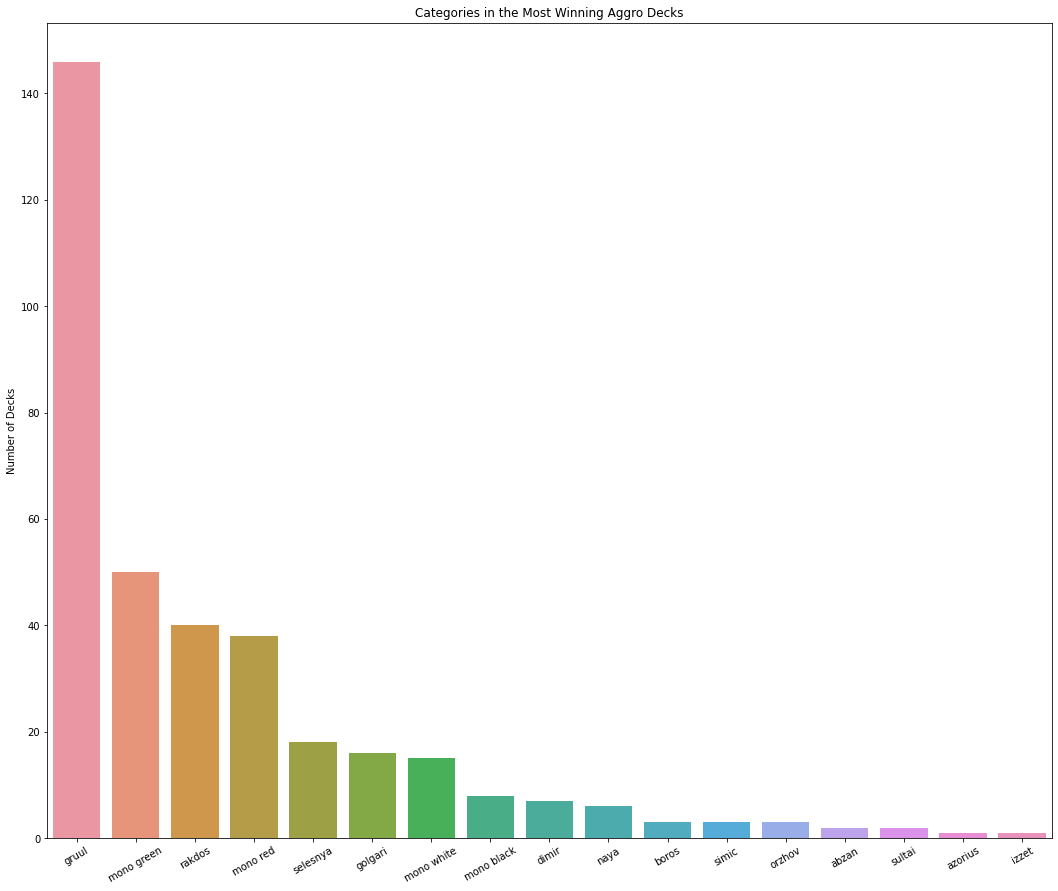

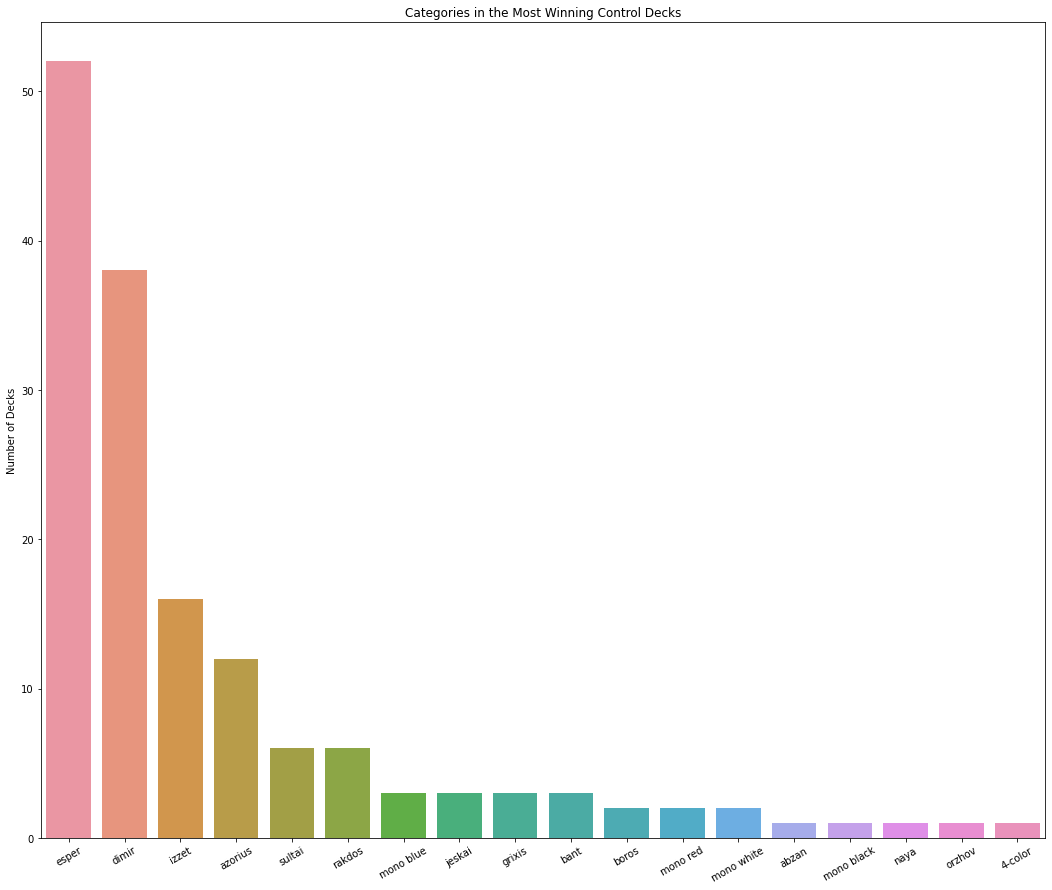

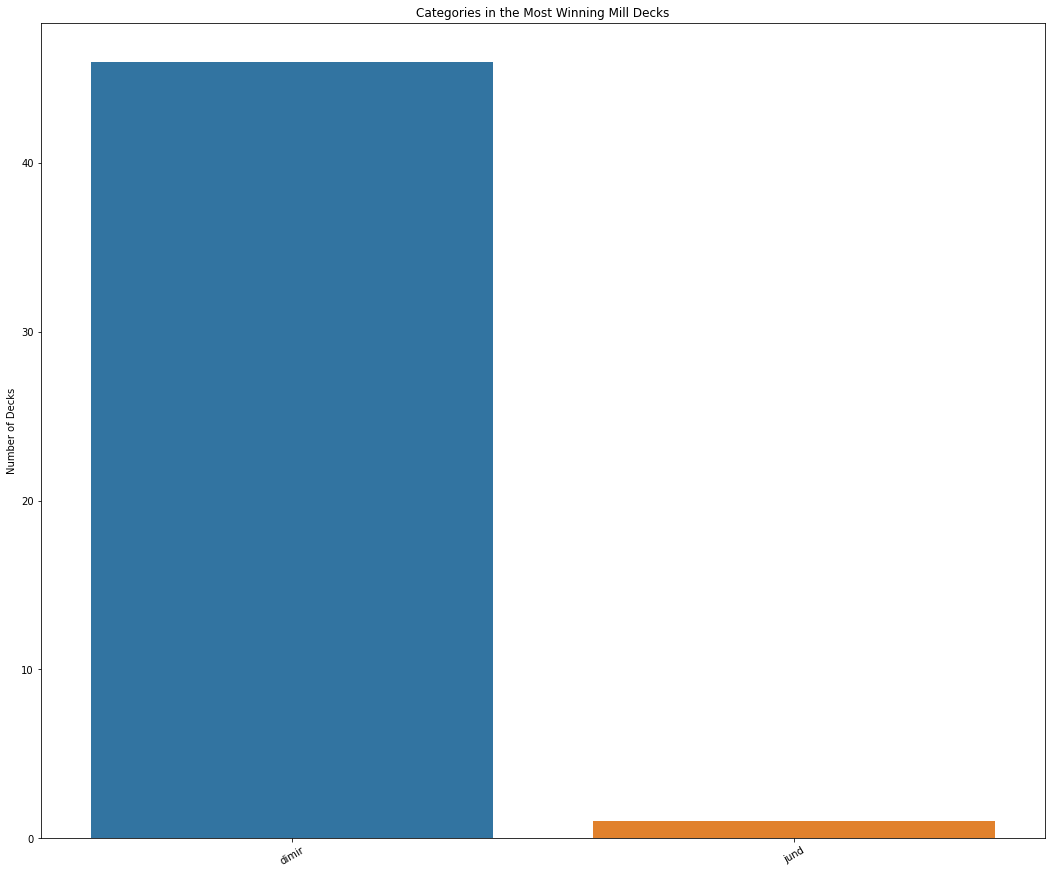

In [16]:
def topn_colors_archetypes(df, n=10, show=False, pdf=None):
    topn_archetypes = df["archetype"].value_counts().index[:n].tolist()
    for archetype in topn_archetypes:
        colors_and_archetypes(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_colors_archetypes(first_place_decks, show=True, n=3)

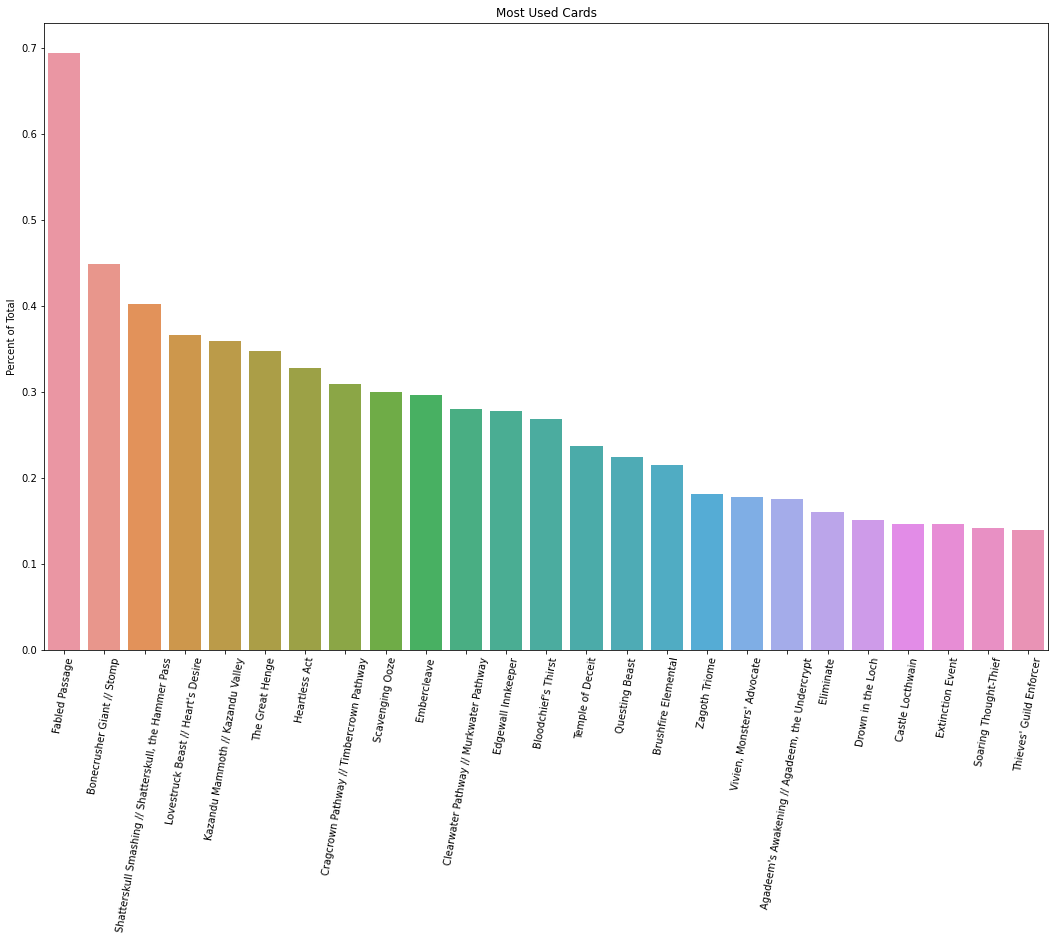

In [17]:
def most_used_cards_graphics(df, show=False):
    this_full_table = df.copy()
    grouped_table = (
        this_full_table
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(this_full_table["deckId"].nunique())
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table.iloc[:25], x="name", y="pct_total")
    plt.title("Most Used Cards")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80)
    plt.xlabel("")
    plt.ylabel("Percent of Total")
    if show:
        plt.show()
    
most_used_cards_graphics(main_decks, show=True)

In [18]:
def most_used_cards_in_archetype(df, archetype, show=False):
    this_df = df[df["archetype"] == archetype].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:30], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80)
    plt.title(f"Most Used Cards in {archetype.title()} Decks")
    plt.ylabel("Percent of All Cards")
    plt.xlabel("")
    if show:
        plt.show()

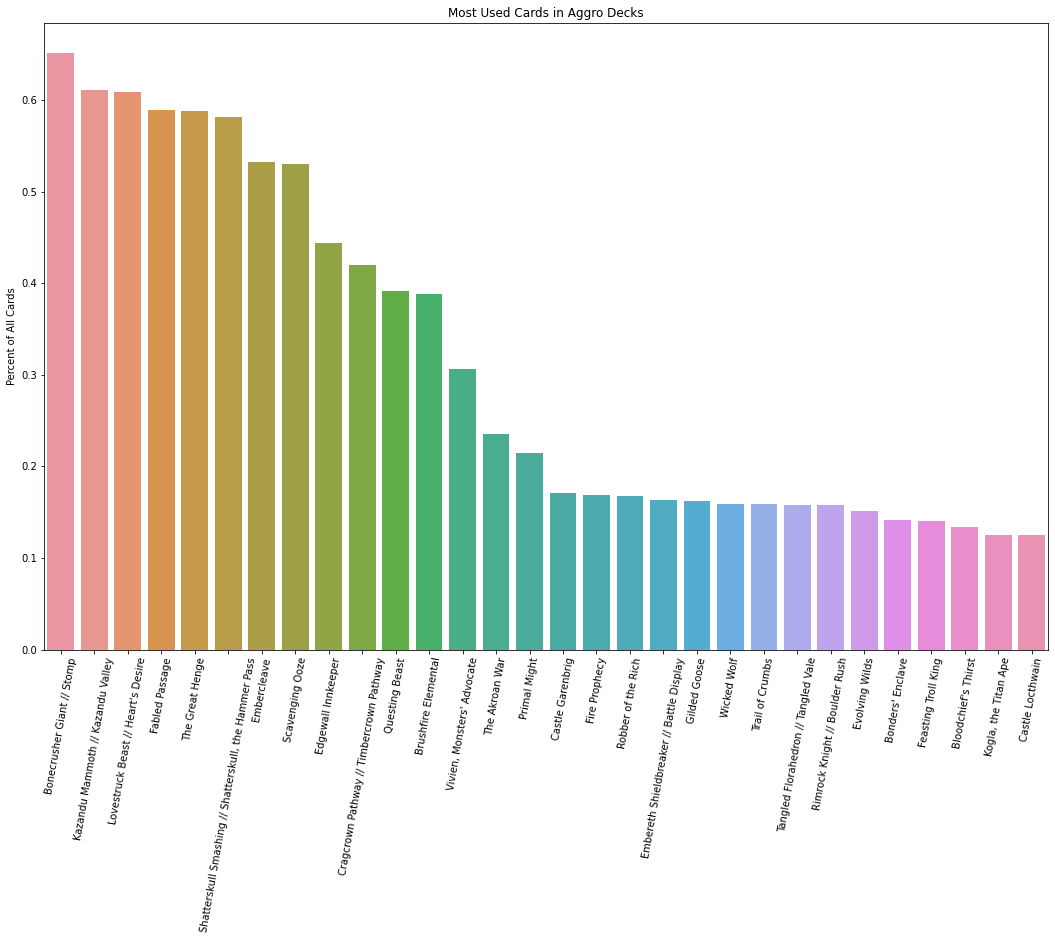

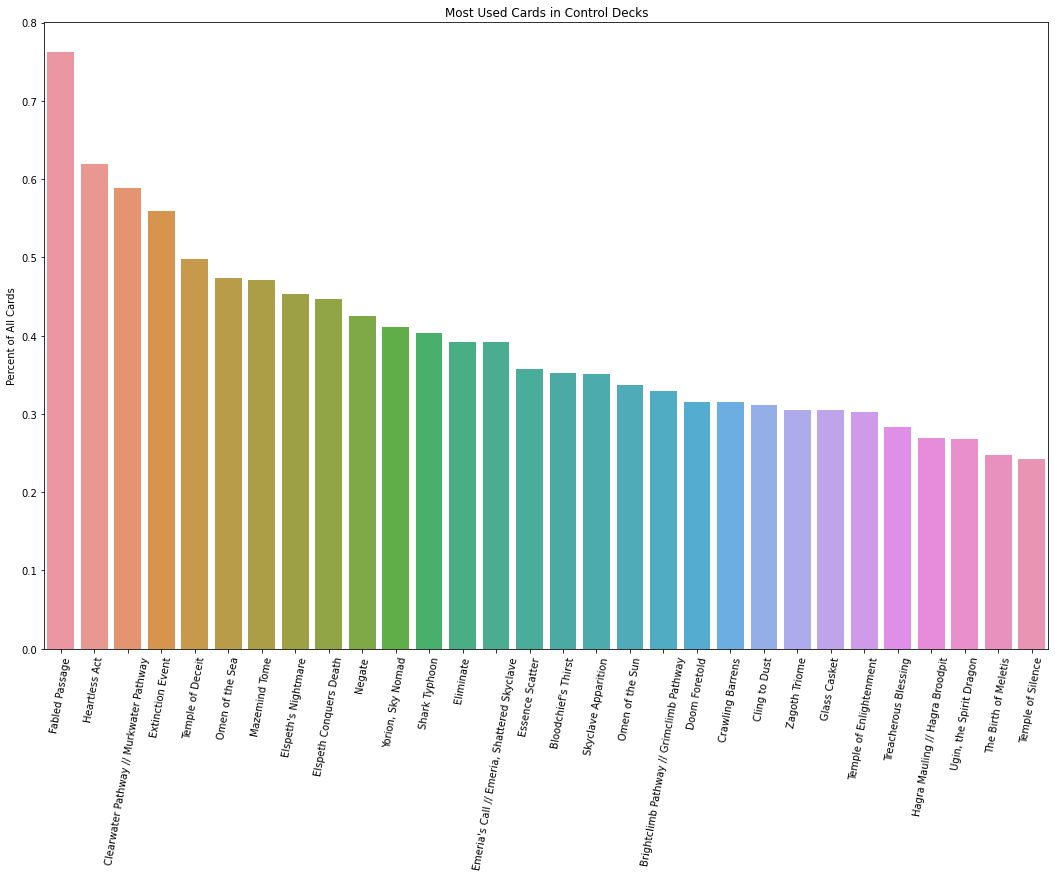

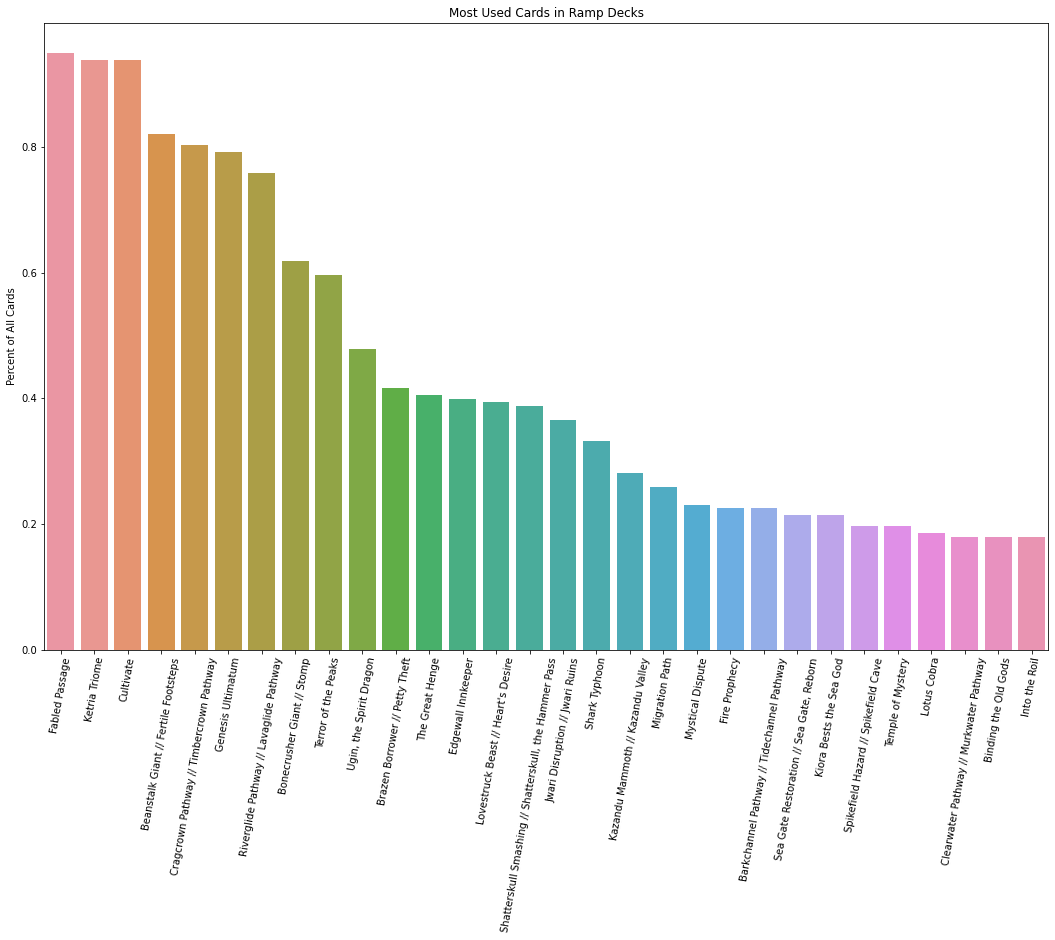

In [19]:
def topn_archetypes(df, n=10, show=False, pdf=None):
    topn_archetypes = deck_table["archetype"].value_counts().index[:n]
    for archetype in topn_archetypes:
        most_used_cards_in_archetype(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_archetypes(main_decks, n=3, show=True)

In [20]:
def most_used_cards_in_category(df, category, show=False):
    this_df = df[df["category"] == category].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:25], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"The Top Cards for {category.title()} Decks")
    plt.ylabel("Percent of Total Decks")
    plt.xlabel("")
    plt.xticks(rotation=80)
    if show:
        plt.show()

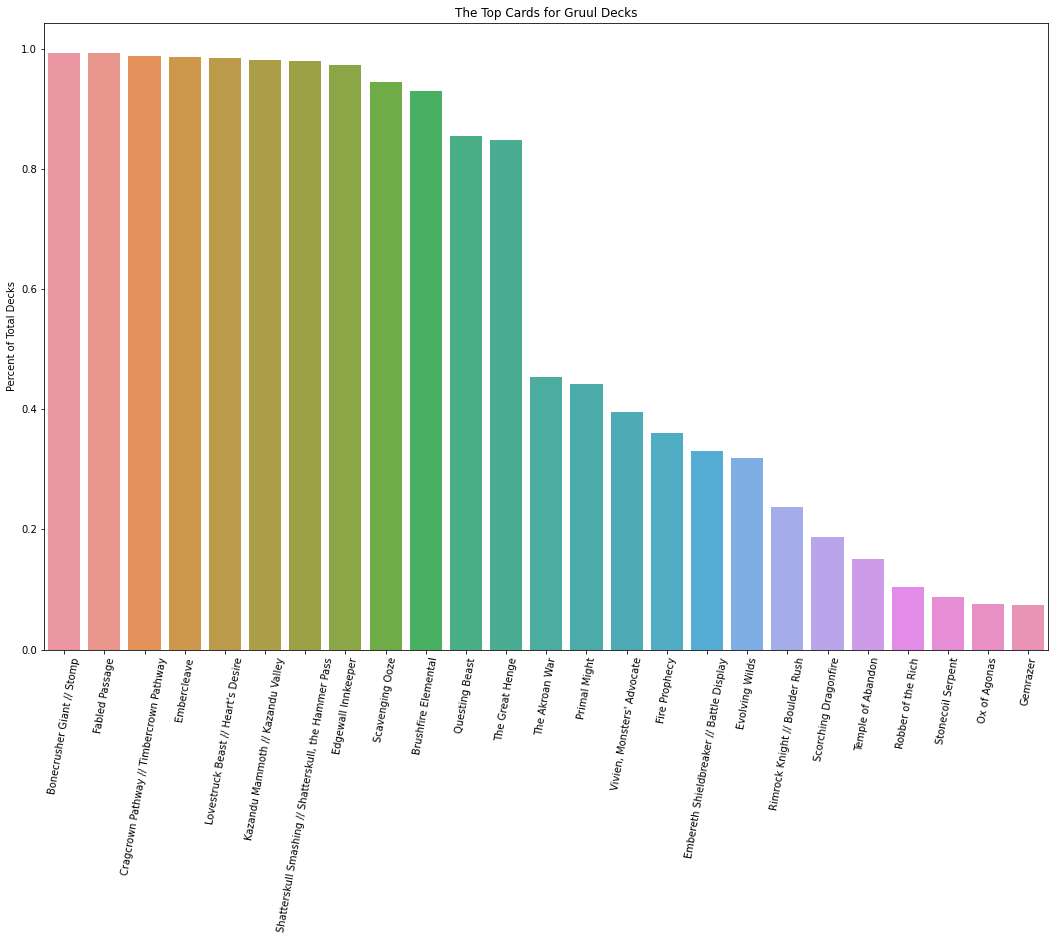

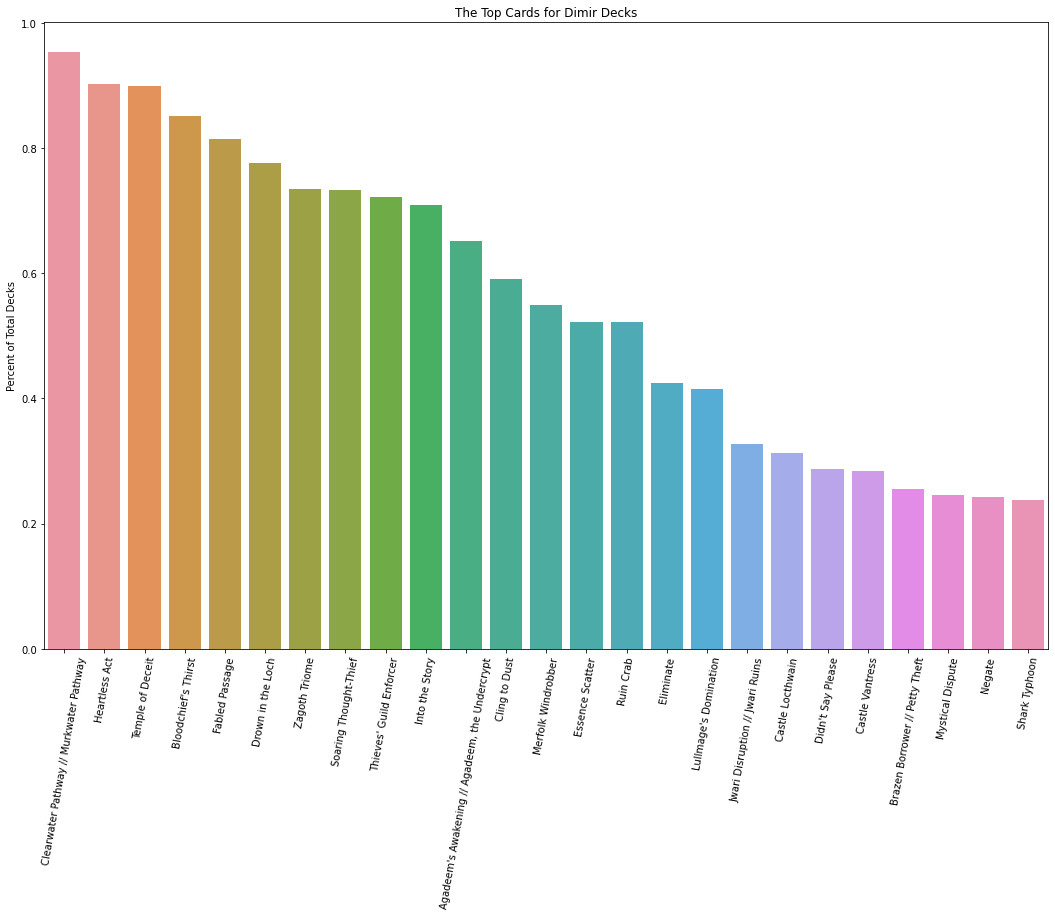

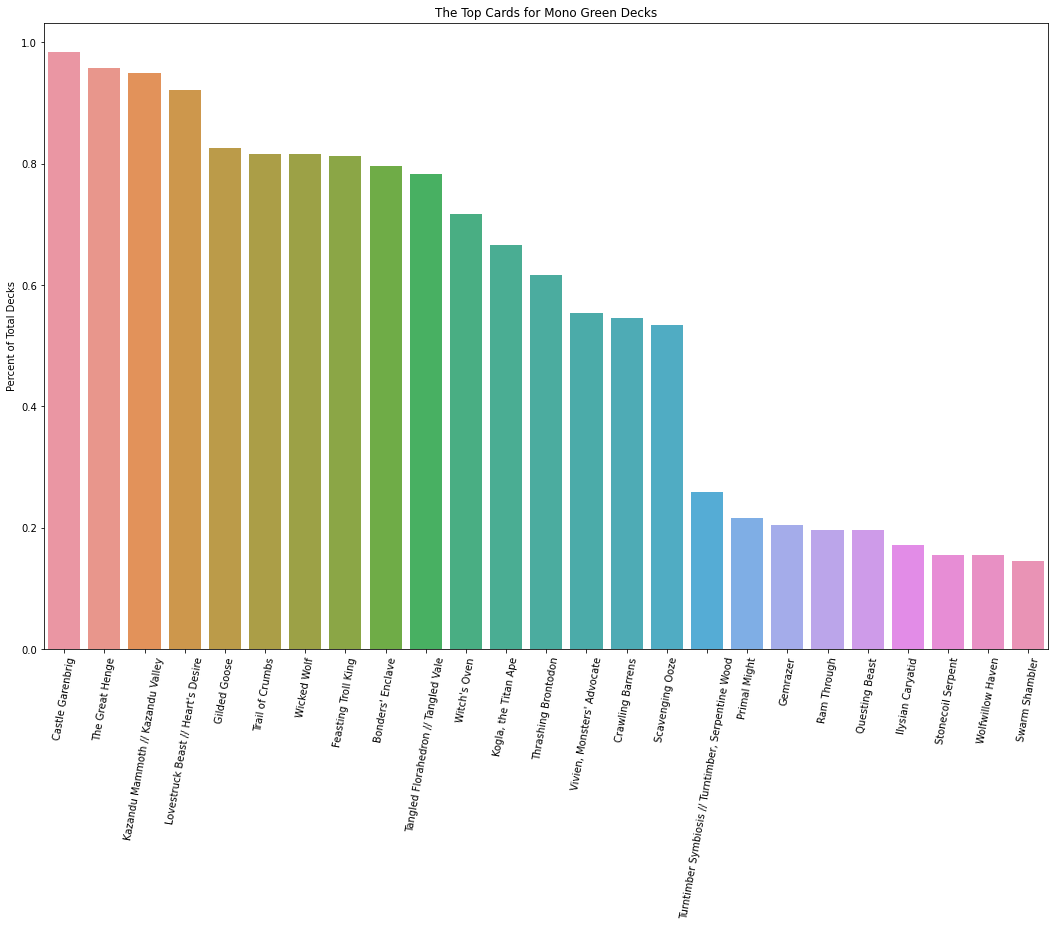

In [21]:
def topn_categories(df, n=10, show=False, pdf=None):
    topn_categories = deck_table["category"].value_counts().index[:n]
    for category in topn_categories:
        most_used_cards_in_category(df, category, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_categories(main_decks, n=3, show=True)

In [22]:
def cards_by_set(df, unique_cards=False, show=False):
    this_df = df[df["deckId"].isin(first_place_decks["deckId"])].copy()
    title = "Cards"
    if unique_cards:
        this_df.drop_duplicates(subset="name", inplace=True)
        title="Unique Cards"
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    plt.figure(figsize=(18, 15))
    sns.countplot(x=this_df["set"], order=this_df["set"].value_counts().index)
    plt.title(f"{title} Used Per Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()
    

In [23]:
first_place_decks

deckId  eventId  pilotId                            deckUrl  \
0          1        1        3             ?e=27938&d=421597&f=ST   
2          3        2        5             ?e=27939&d=421599&f=ST   
3          4        3        6             ?e=27940&d=421600&f=ST   
4          5        4        7             ?e=27925&d=421512&f=ST   
12        13        5       15             ?e=27918&d=421478&f=ST   
16        17        6       19             ?e=27921&d=421484&f=ST   
24        25        7       26             ?e=27886&d=421193&f=ST   
26        27        8       28             ?e=27898&d=421353&f=ST   
30        31        9       32             ?e=27901&d=421373&f=ST   
38        39       10       39             ?e=27902&d=421381&f=ST   
42        43       11       43             ?e=27919&d=421482&f=ST   
43        44       12       44             ?e=27920&d=421483&f=ST   
44        45       13       45             ?e=27941&d=421601&f=ST   
46        47       14       47             ?e=27876&d=421119&f=ST   
54        55       15       54             ?e=27885&d=421189&f=ST   
58        59       16       57             ?e=27888&d=421199&f=ST   
66        67       17       65             ?e=27905&d=421389&f=ST   
74        75       18       73             ?e=27860&d=421013&f=ST   
82        83       19       81             ?e=27863&d=421032&f=ST   
85        86       20       84             ?e=27877&d=421127&f=ST   
93        94       21       91             ?e=27878&d=421135&f=ST   
101      102       22       99  ?e=27894&d=421299&f=ST&show_pts=Y   
121      122       23      119             ?e=27900&d=421365&f=ST   
129      130       24      127             ?e=27842&d=420939&f=ST   
137      138       25      135             ?e=27847&d=420959&f=ST   
139      140       26      137             ?e=27855&d=420991&f=ST   
141      142       27      138             ?e=27857&d=420995&f=ST   
143      144       28      140             ?e=27859&d=421005&f=ST   
151      152       29      148             ?e=27889&d=421207&f=ST   
155      156       30      152  ?e=27893&d=421249&f=ST&show_pts=Y   
156      157       30      153  ?e=27893&d=421288&f=ST&show_pts=Y   
186      187       31      183             ?e=27834&d=420857&f=ST   
194      195       32       85             ?e=27840&d=420915&f=ST   
202      203       33      198             ?e=27843&d=420947&f=ST   
204      205       34      200             ?e=27845&d=420953&f=ST   
206      207       35       18             ?e=27846&d=420955&f=ST   
210      211       36      204             ?e=27848&d=420961&f=ST   
211      212       37      205             ?e=27853&d=420981&f=ST   
219      220       38      213             ?e=27811&d=420676&f=ST   
227      228       39      221             ?e=27822&d=420766&f=ST   
235      236       40      229             ?e=27823&d=420782&f=ST   
243      244       41      237             ?e=27828&d=420820&f=ST   
244      245       42      238             ?e=27839&d=420907&f=ST   
252      253       43      245             ?e=27814&d=420710&f=ST   
254      255       44      247             ?e=27786&d=420536&f=ST   
262      263       45      254             ?e=27787&d=420544&f=ST   
270      271       46       15             ?e=27788&d=420552&f=ST   
278      279       47      268             ?e=27792&d=420580&f=ST   
280      281       48      270             ?e=27805&d=420643&f=ST   
282      283       49       40             ?e=27808&d=420660&f=ST   
286      287       50       84             ?e=27778&d=420464&f=ST   
294      295       51      280             ?e=27785&d=420520&f=ST   
302      303       52      287             ?e=27791&d=420572&f=ST   
310      311       53      295             ?e=27801&d=420633&f=ST   
312      313       54      297             ?e=27802&d=420635&f=ST   
314      315       55       18             ?e=27803&d=420637&f=ST   
318      319       56      301             ?e=27807&d=420659&f=ST   
319 

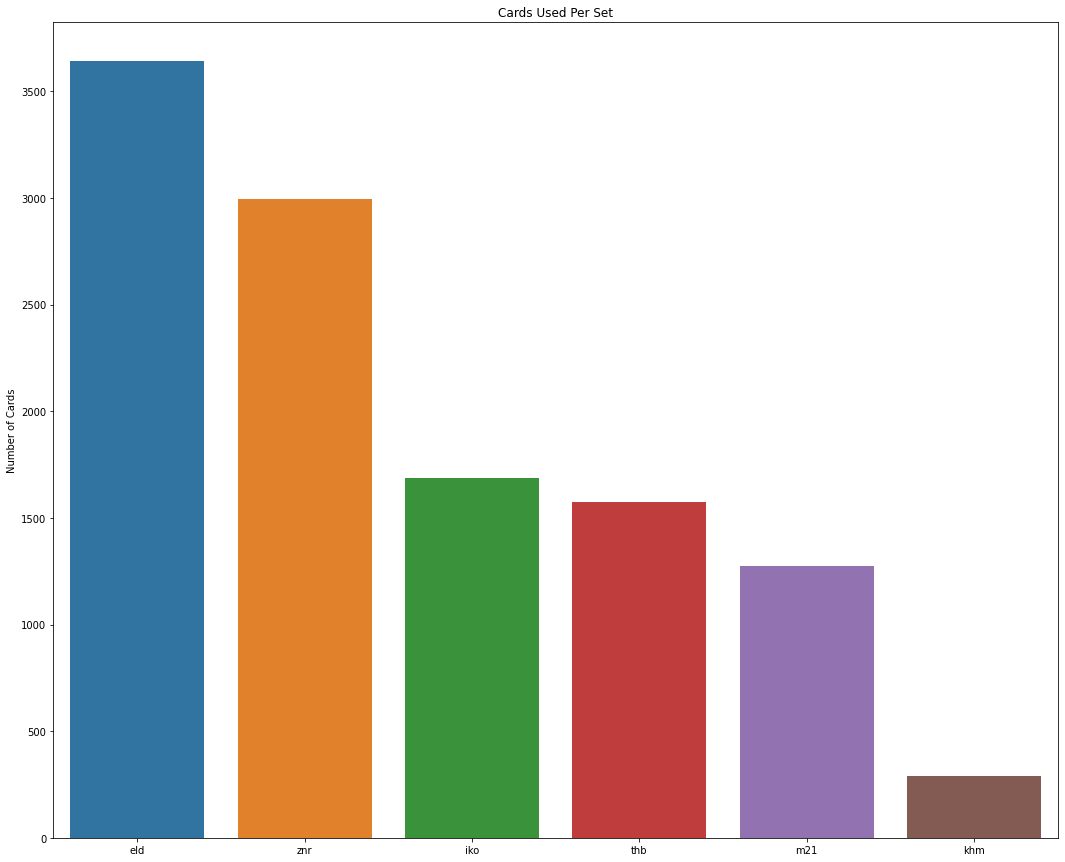

In [24]:
cards_by_set(main_decks,show=True)

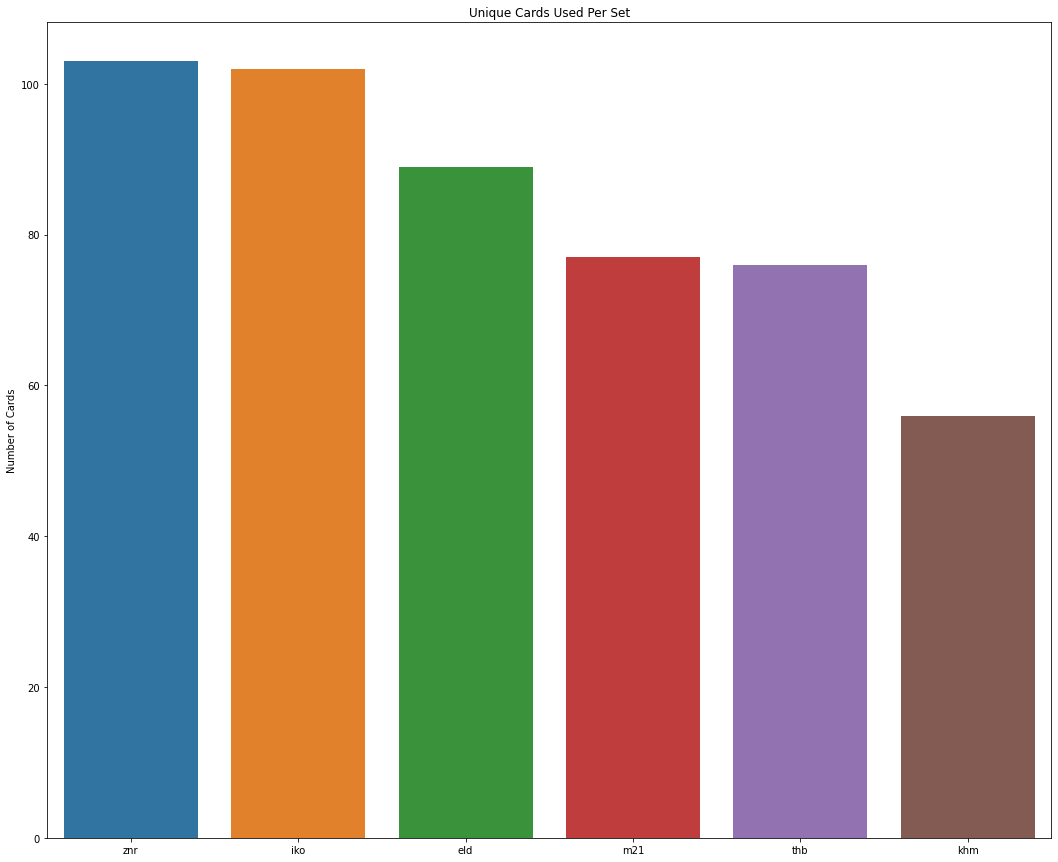

In [25]:
cards_by_set(main_decks,unique_cards=True, show=True)

In [26]:
def sort_by_date(df):
    date_order = []
    for year in ["2020", "2021"]:
        for month in [
            "January", "February", "March", "April", 
            "May", "June", "July", "August", 
            "September", "October", "November", "December"
        ]:
            date_order.append(f"{month} {year}")
    this_df = df.copy()
    
    this_df["month_year"] = pd.Categorical(
        this_df["date"].dt.month_name() + " " + (this_df["date"].dt.year).astype("str"),
        date_order,
        ordered=True
    )
    
    this_df["day"] = this_df["date"].dt.day
    
    return this_df.sort_values(by=["month_year", "day"])

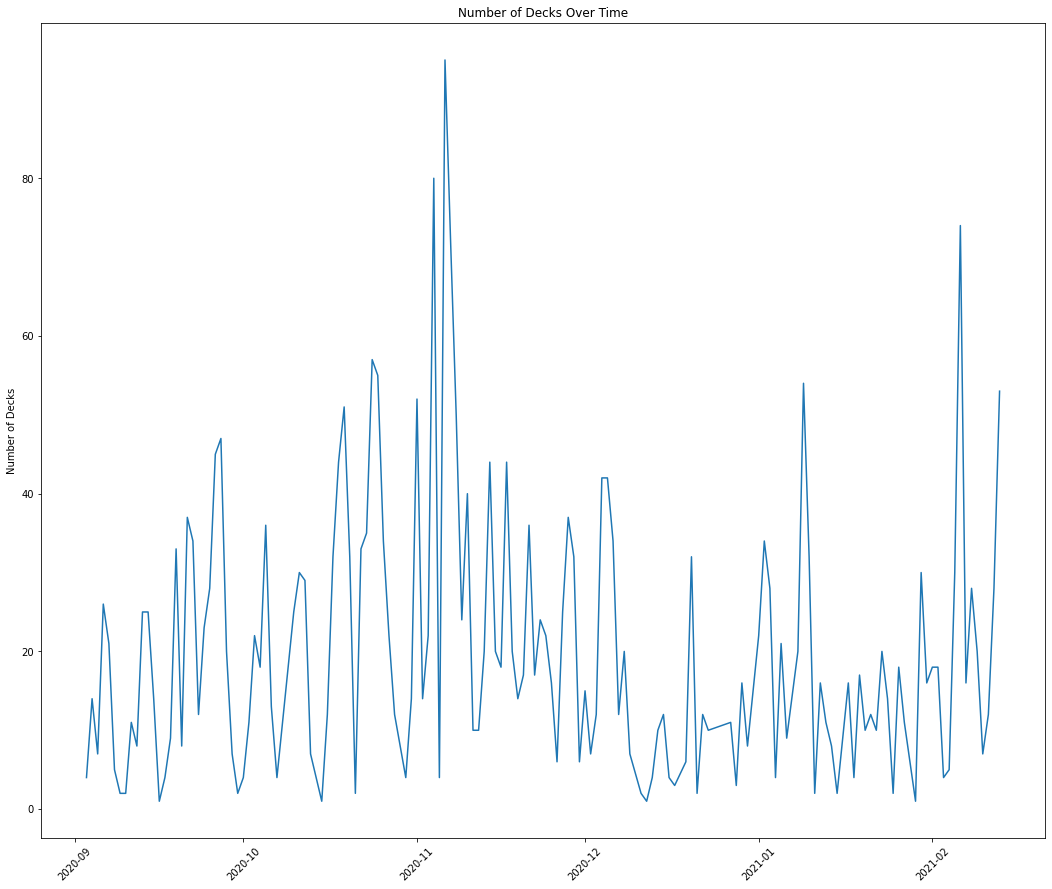

In [27]:
def number_of_decks_over_time(df, show=False):
    this_df = sort_by_date(df)
    grouped_df= (
        this_df
        .groupby(["date"])["deckId"]
        .nunique()
        .reset_index()
    )
    
    plt.figure(figsize=(18, 15))
    plt.plot(grouped_df["date"], grouped_df["deckId"])
    plt.xticks(rotation=45)
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks Over Time")
    if show:
        plt.show()
    
    
number_of_decks_over_time(full_table, show=True)

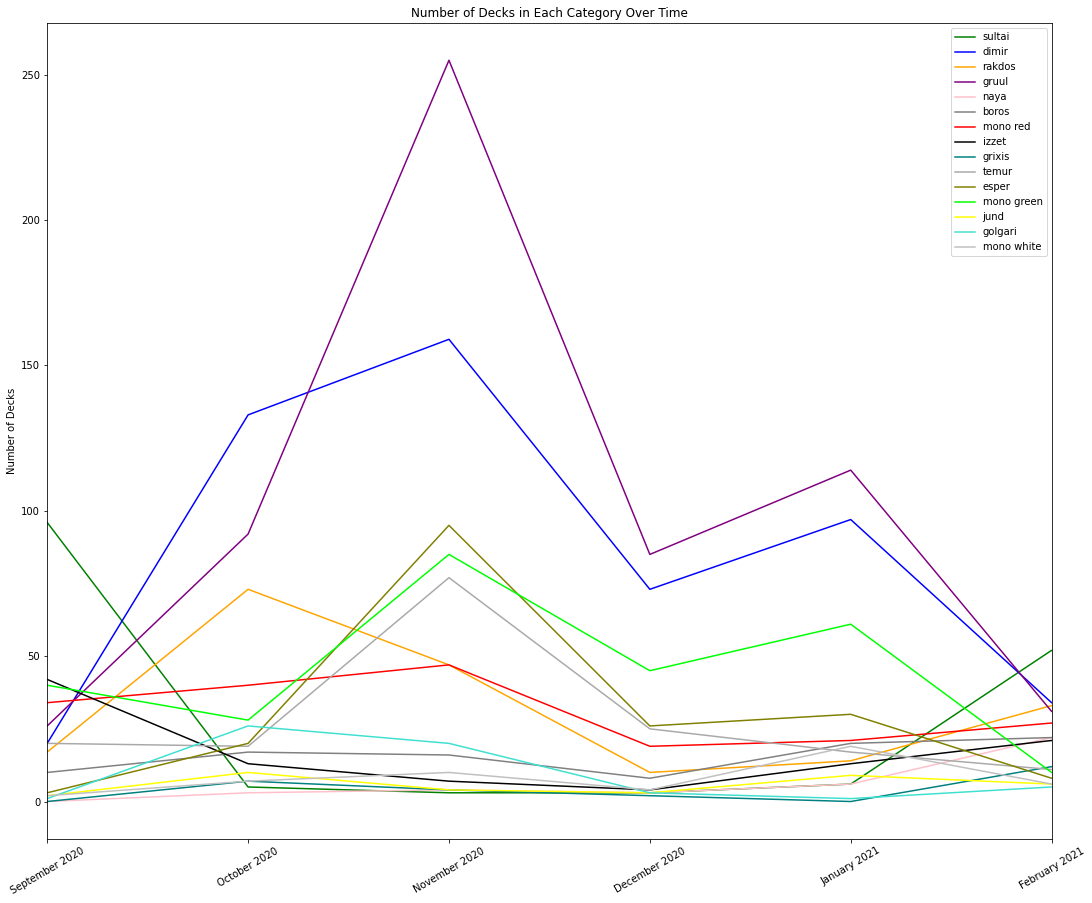

In [28]:
def categories_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "category"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_categories = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["category"].value_counts().index[:15]
    colors = ["green", "blue", "orange", "purple", "pink",
              "grey", "red", "black", "teal", "darkgrey",
              "olive", "lime", "yellow", "turquoise", "silver"
             ]
    plt.figure(figsize=(18, 15))
    for cat, color in zip(top_categories, colors):
        cat_df = grouped_df[grouped_df["category"]==cat]
        plt.plot(cat_df["month_year"], cat_df["deckId"], label=cat, color=color)
    
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks in Each Category Over Time")
    plt.legend()
    if show:
        plt.show()
    
categories_over_time(full_table, show=True)

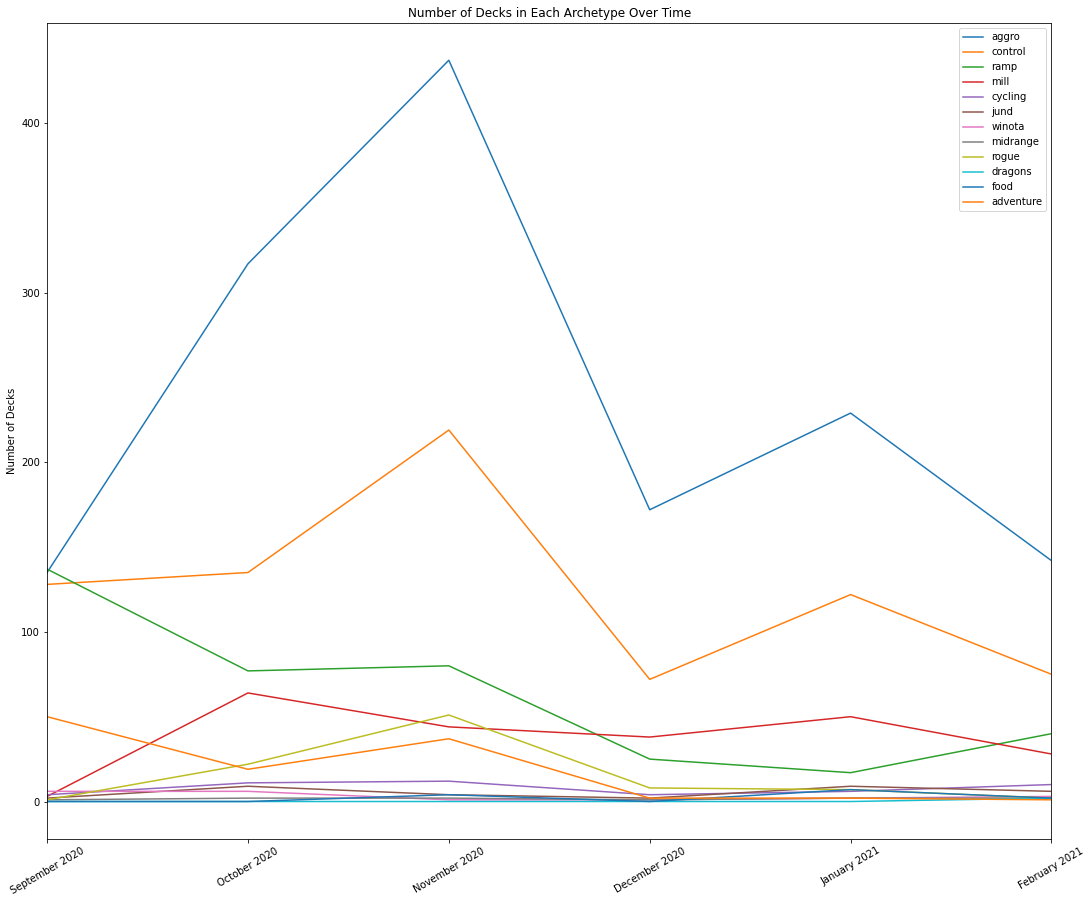

In [29]:
def archetypes_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "archetype"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_archetypes = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["archetype"].value_counts().index[:15]
    
    plt.figure(figsize=(18, 15))
    for archetype in top_archetypes:
        archetype_df = grouped_df[grouped_df["archetype"]==archetype]
        plt.plot(archetype_df["month_year"], archetype_df["deckId"], label=archetype)
    
    plt.title("Number of Decks in Each Archetype Over Time")
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])   
    plt.ylabel("Number of Decks")
    plt.legend()
    if show:
        plt.show()
    
archetypes_over_time(full_table, show=True)

In [30]:
def arena_vs_nonarena(df):
    this_df = df.copy()
    this_df["is_arena"] = df.apply(lambda x: "arena" if "arena" in x["name_event"].lower() else "not_arena", axis=1)
    arena_freq = pd.crosstab(this_df["archetype"], this_df["is_arena"])
    _, pval, _, _ = chi2_contingency(arena_freq)
    return pval
    

In [31]:
arena_vs_nonarena(full_table)

0.0

In [32]:
masked_table = full_table.copy()

In [33]:
cat_count = masked_table["category"].value_counts()

In [34]:
cat_count

gruul         14966
dimir         14330
mono green     6403
esper          6233
4-color        6066
sultai         5472
rakdos         5249
temur          4517
mono red       3783
izzet          2819
boros          2313
azorius        1897
golgari        1585
selesnya       1358
mono white     1075
naya           1015
jund           1002
mono black      820
grixis          723
abzan           717
orzhov          437
jeskai          392
bant            295
simic           268
mono blue       253
mardu           135
colorless        94
5-color          75
Name: category, dtype: int64

In [35]:
mask = masked_table["category"].isin(cat_count[cat_count < 2000].index)

In [36]:
mask

0        False
1        False
2        False
3        False
4        False
         ...  
84287    False
84288    False
84289    False
84290    False
84291    False
Name: category, Length: 84292, dtype: bool

In [37]:
masked_table["category"][mask] = "other"

<ipython-input-37-367f14b33268>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_table["category"][mask] = "other"


In [38]:
masked_table

eventId                                        name_event       date  \
0            1                          FNM @ MTG Arena Campania 2020-10-30   
1            1                          FNM @ MTG Arena Campania 2020-10-30   
2            1                          FNM @ MTG Arena Campania 2020-10-30   
3            1                          FNM @ MTG Arena Campania 2020-10-30   
4            1                          FNM @ MTG Arena Campania 2020-10-30   
...        ...                                               ...        ...   
84287      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84288      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84289      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84290      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84291      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   

       deckId  pilotId      name_deck firstName  lastName  cardId  \
0           1        3    Gruul Aggro    Antimo  Morlando  261znr   
1           1        3    Gruul Aggro    Antimo  Morlando  244eld   
2           1        3    Gruul Aggro    Antimo  Morlando  266eld   
3           1        3    Gruul Aggro    Antimo  Morlando  262eld   
4           1        3    Gruul Aggro    Antimo  Morlando  115eld   
...       ...      ...            ...       ...       ...     ...   
84287    3136      110  Sultai Yorion      Seth  Manfield  087thb   
84288    3136      110  Sultai Yorion      Seth  Manfield  096m21   
84289    3136      110  Sultai Yorion      Seth  Manfield  127znr   
84290    3136      110  Sultai Yorion      Seth  Manfield  179m21   
84291    3136      110  Sultai Yorion      Seth  Manfield  088iko   

                                           name  count color slot archetype  \
0      Cragcrown Pathway // Timbercrown Pathway      4    GR   md     aggro   
1                                Fabled Passage      4   NaN   md     aggro   
2                                        Forest      9     G   md     aggro   
3                                      Mountain      5     R   md     aggro   
4                    Bonecrusher Giant // Stomp      4     R   md     aggro   
...                                         ...    ...   ...  ...       ...   
84287                             Cling to Dust      2     B   sb   control   
84288                                    Duress      3     B   sb   control   
84289                              Soul Shatter      1     B   sb   control   
84290                           Elder Gargaroth      2     G   sb   control   
84291                          Extinction Event      2     B   sb   control   

      category       latest_set  
0        gruul  Zendikar Rising  
1        gruul  Zendikar Rising  
2        gruul  Zendikar Rising  
3        gruul  Zendikar Rising  
4        gruul  Zendikar Rising  
...        ...              ...  
84287   sultai         Kaldheim  
84288   sultai         Kaldheim  
84289   sultai         Kaldheim  
84290   sultai         Kaldheim  
84291   sultai         Kaldheim  

[84292 rows x 16 columns]

In [39]:
masked_table["category"].value_counts()

gruul         14966
dimir         14330
other         12141
mono green     6403
esper          6233
4-color        6066
sultai         5472
rakdos         5249
temur          4517
mono red       3783
izzet          2819
boros          2313
Name: category, dtype: int64

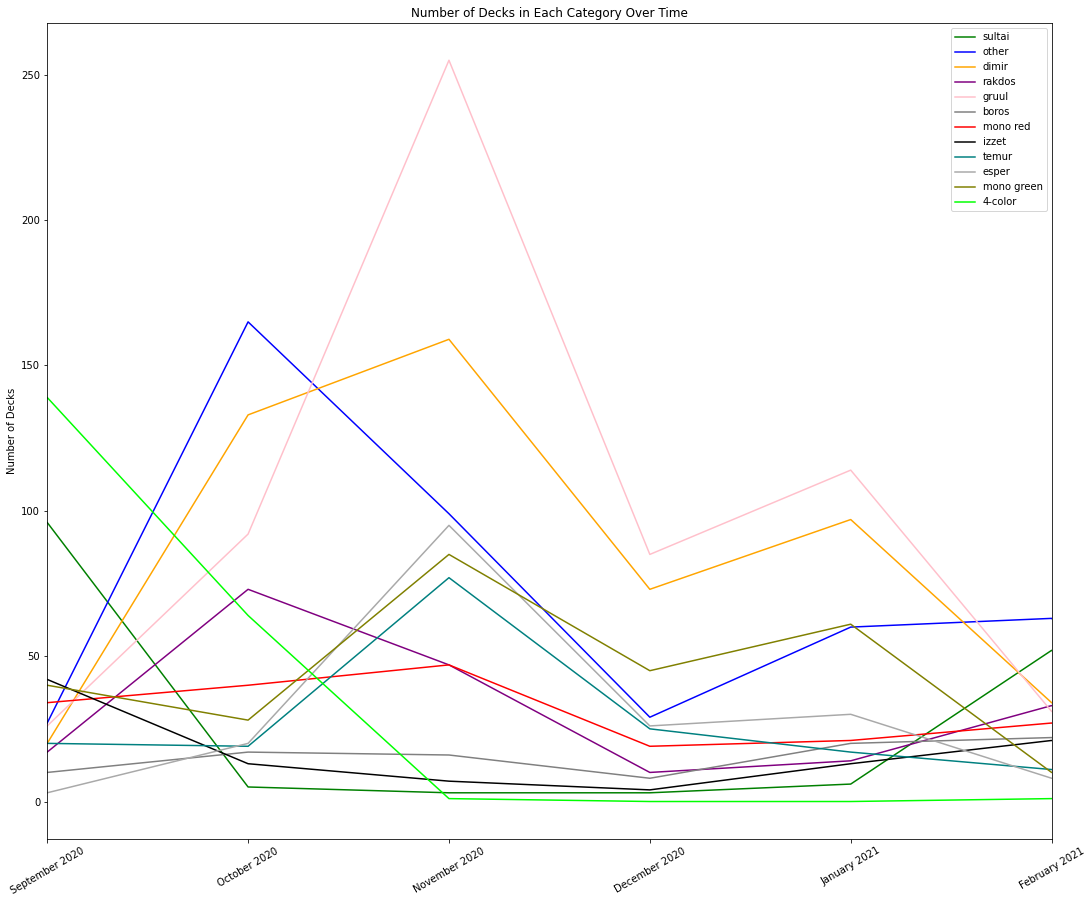

In [40]:
categories_over_time(masked_table)

In [41]:
def color_dominance(df, color, show=False):
    this_df = df.copy().fillna("")
    color_cards = this_df[
        (this_df["color"].str.contains(color))
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=color_cards, x="name", y="count")
    plt.xticks(rotation=80)
    plt.subplots_adjust(bottom=0.3)
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    plt.title(f"Most Used {color.title()} Cards")
    if show:
        plt.show()

In [42]:
def plot_color_dominance(df, show=False, pdf=None):
    for color in ["W", "U", "B", "R", "G"]:
        color_dominance(df, color, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

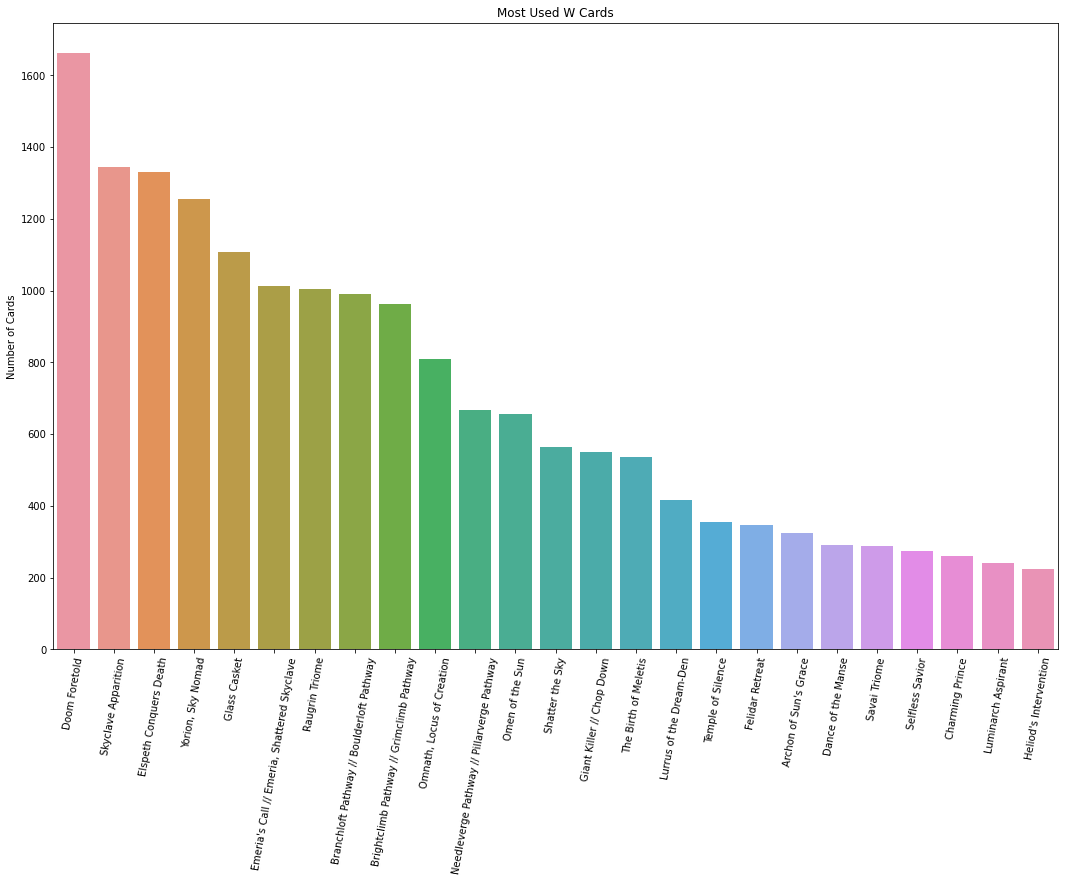

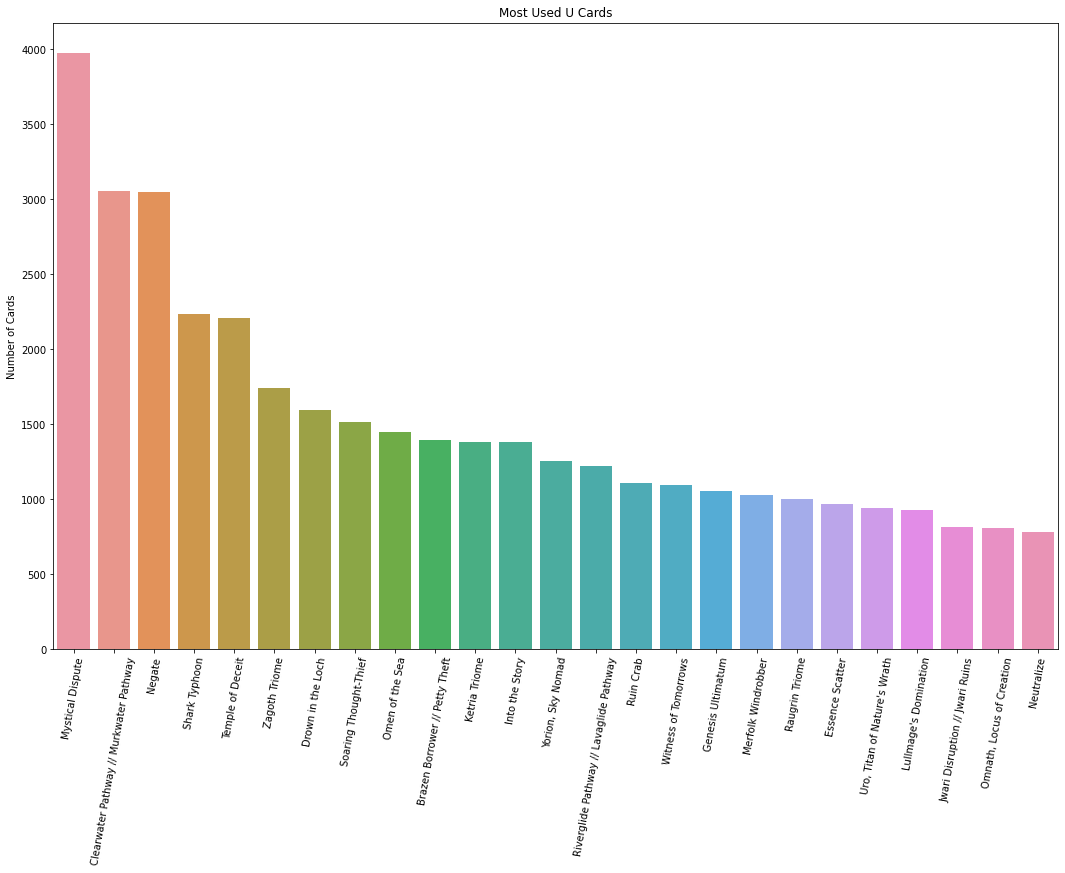

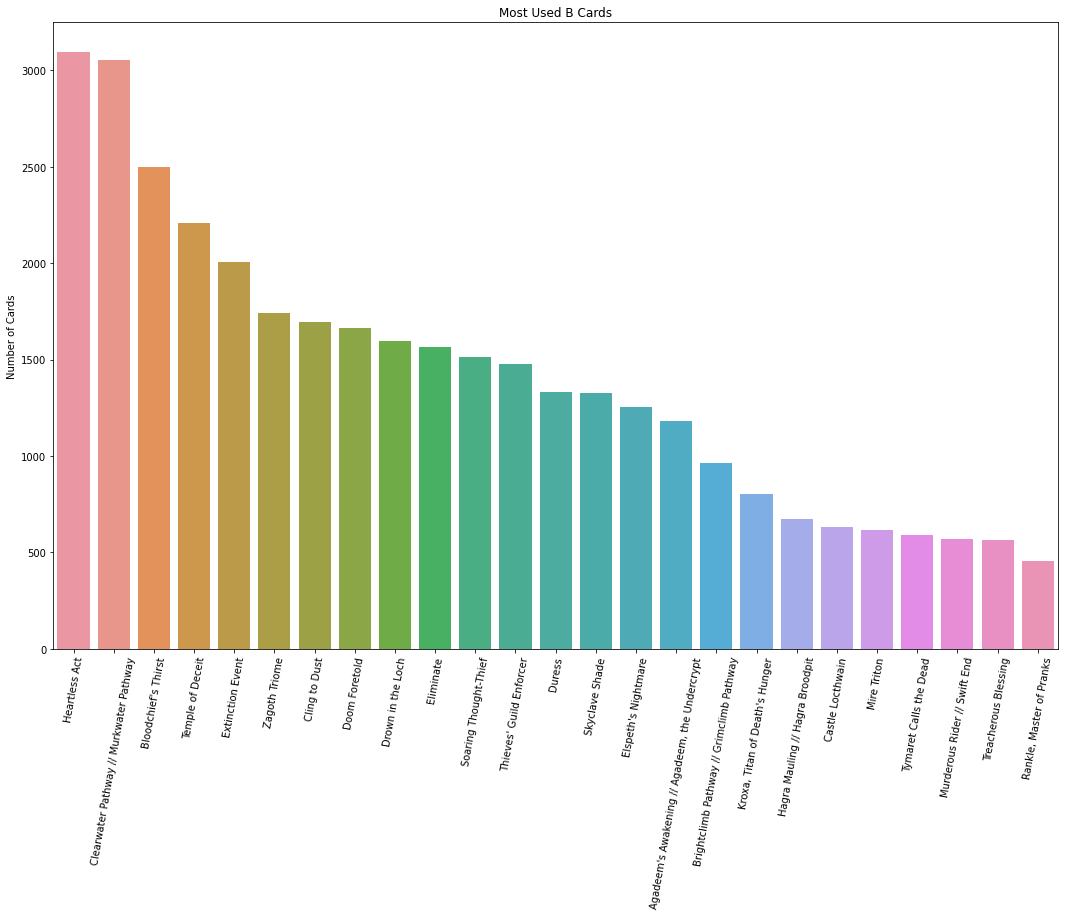

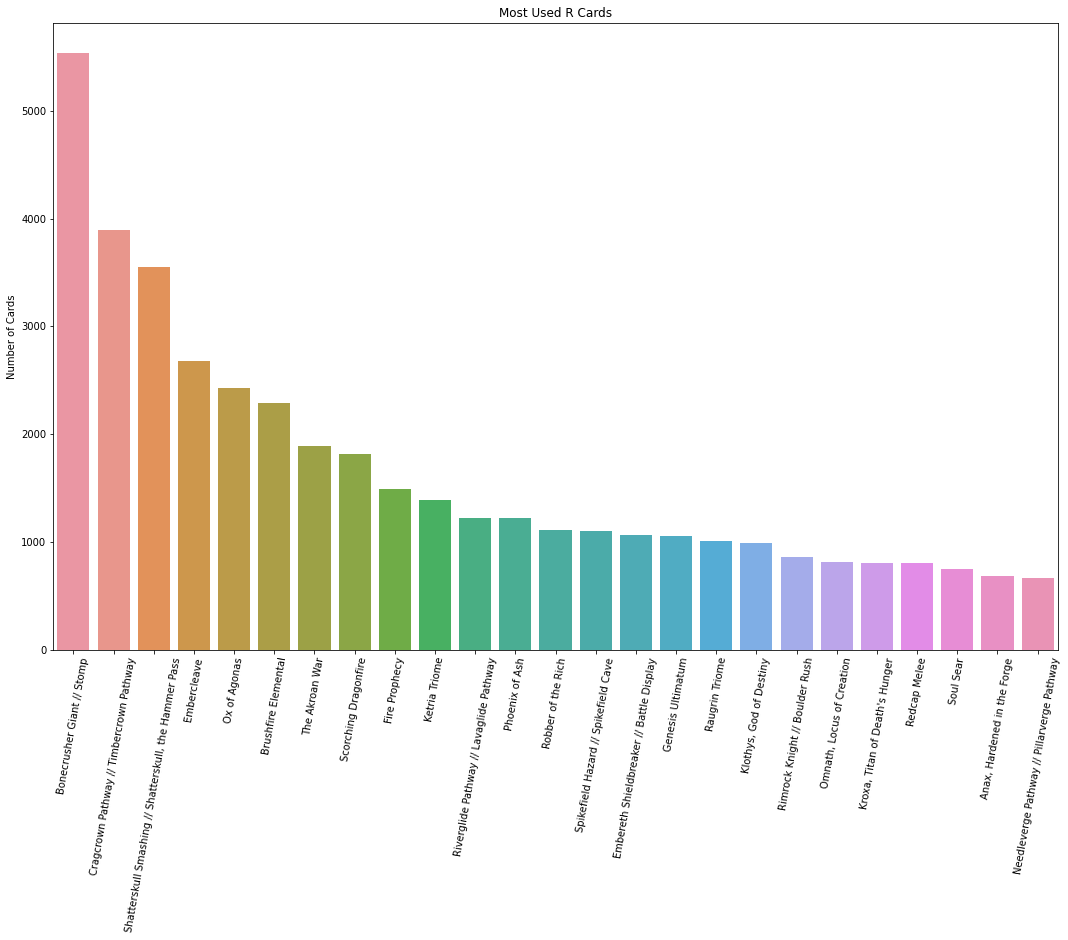

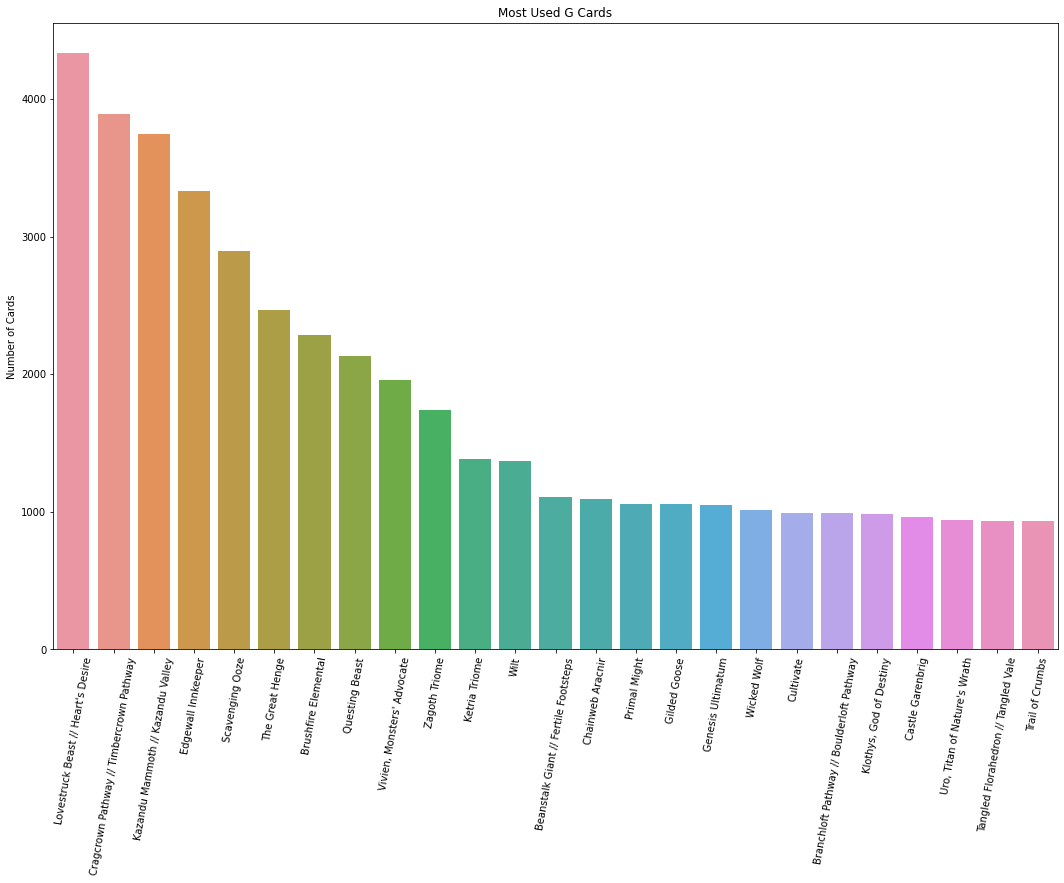

In [43]:
plot_color_dominance(full_table, show=True)

In [44]:
def set_dominance(df, set_code, show=False):
    this_df = df.copy().fillna("")
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    set_df = this_df[
        (this_df["set"] == set_code)
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
        & (~this_df["name"].str.contains("Snow-Covered"))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=set_df, x="name", y="count")
    plt.xticks(rotation=80)
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"Most Used Cards from {set_code.title()} Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()

In [45]:
def plot_set_dominance(df, show=False, pdf=None):
    for set_code in ["eld", "thb", "iko", "znr", "m21", "khm"]:
        set_dominance(df, set_code, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

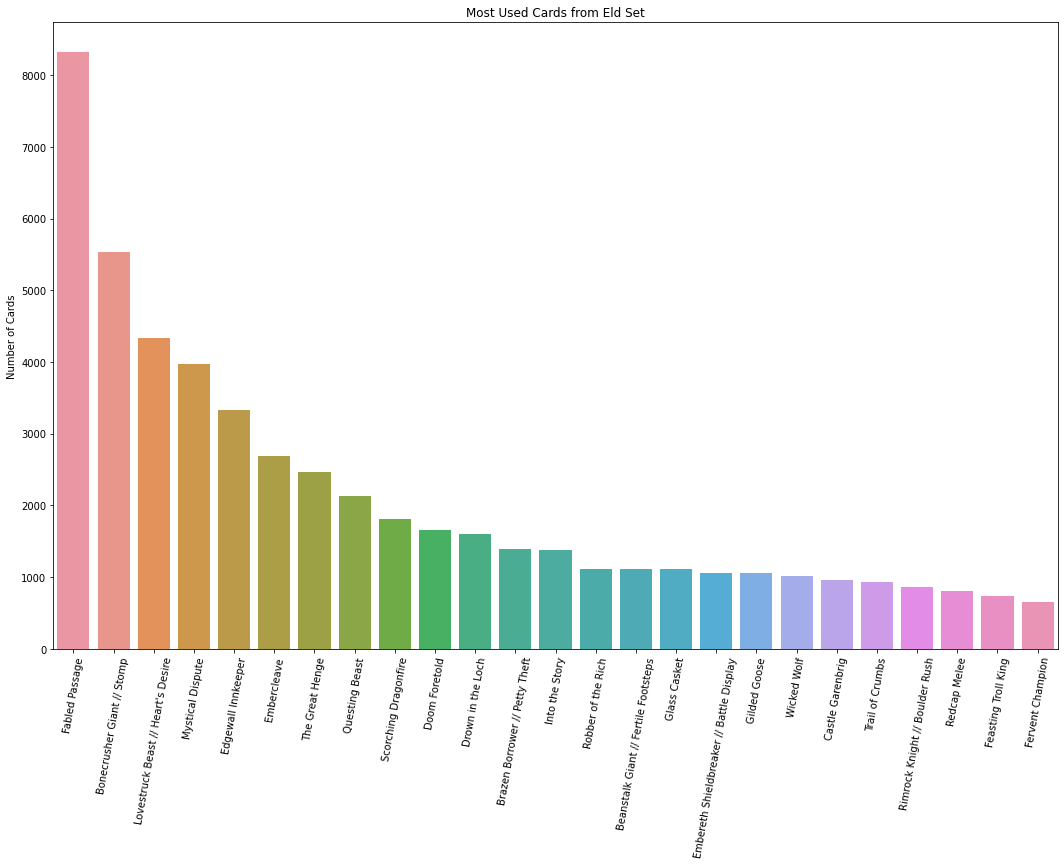

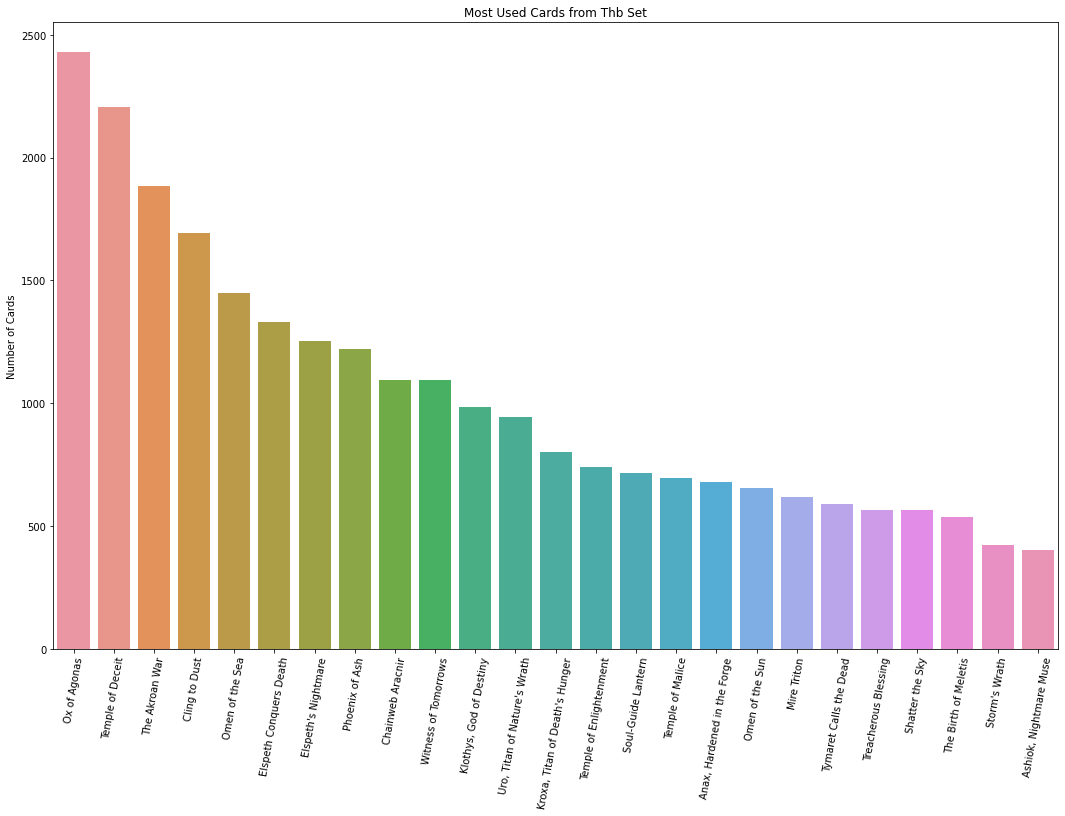

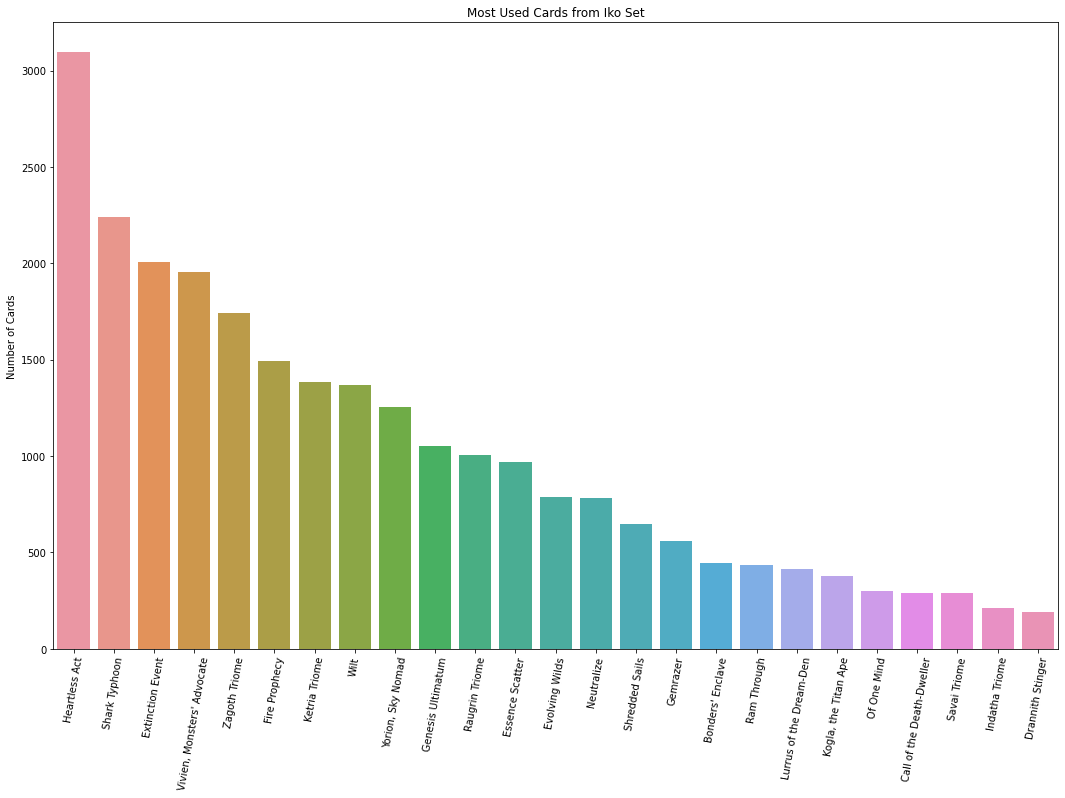

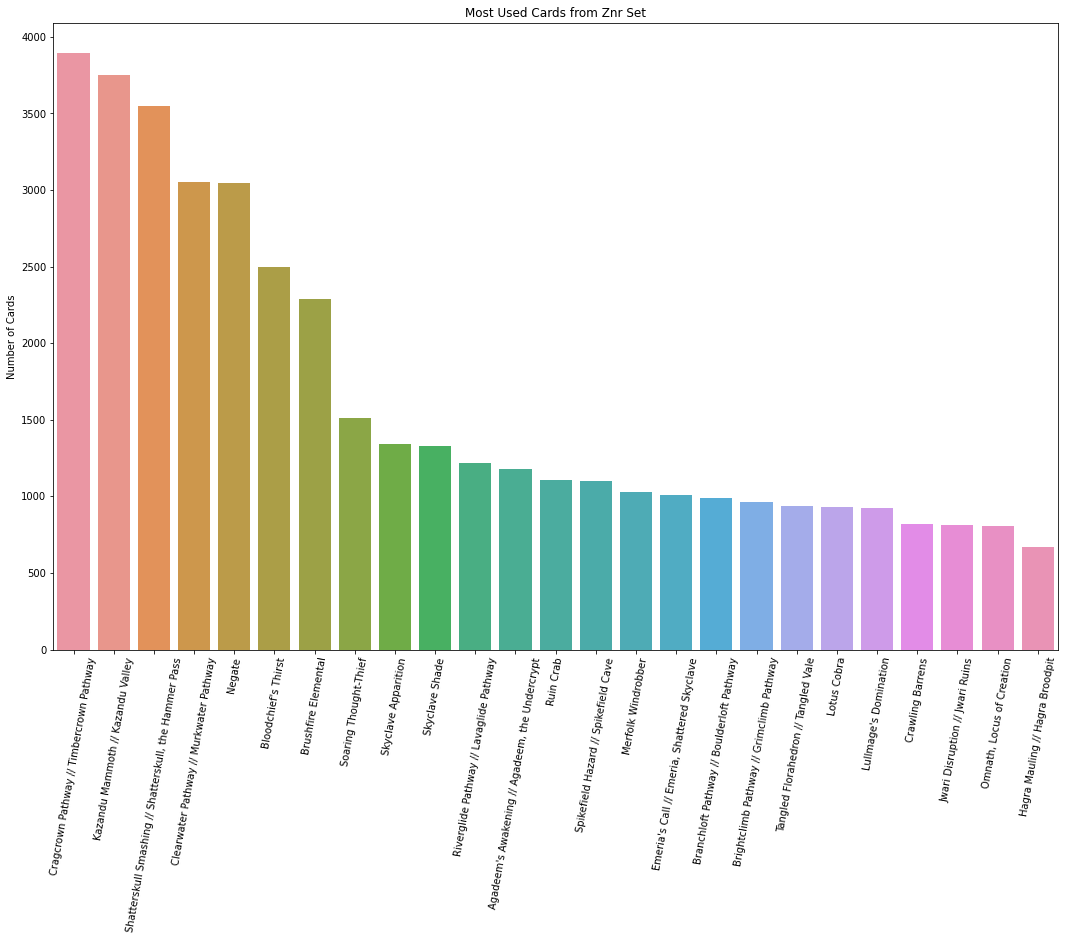

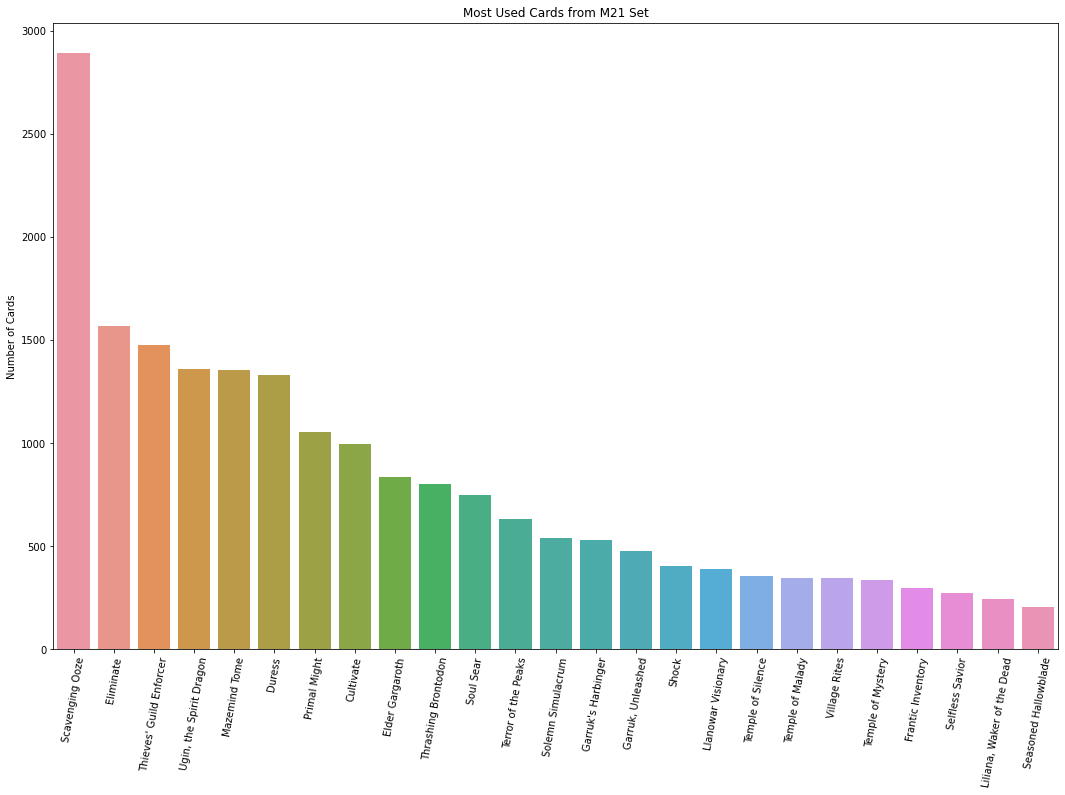

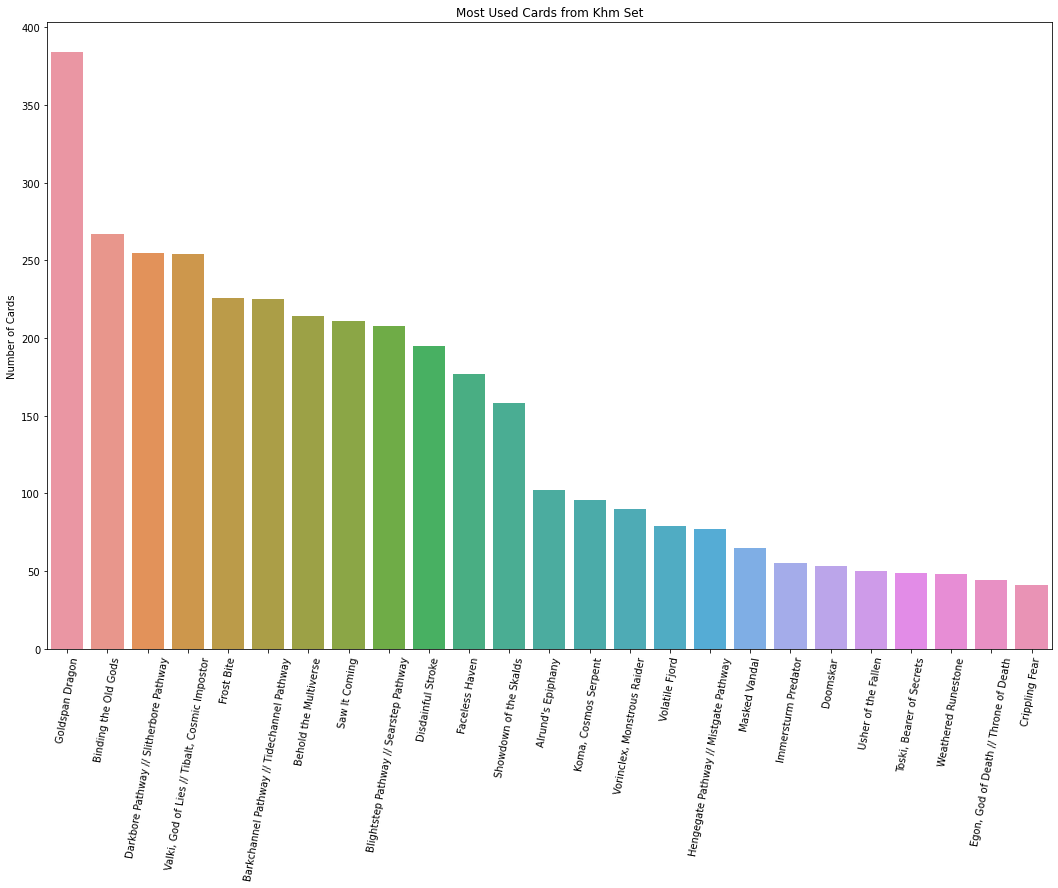

In [46]:
plot_set_dominance(full_table, show=True)

In [47]:
def oracle_text_analysis(df=most_used_cards):
    this_df = (
        df[["name"]]
        .merge(card_table[["name", "oracle_text"]], on="name", how="left")
        .drop_duplicates()
        .copy()
    )
    return this_df[
        (~this_df["name"].str.contains("Triome|Pathway|Fabled Passage", regex=True))
    ]

In [48]:
oracle_texts = oracle_text_analysis()

In [49]:
oracle_texts

name  \
4                                     Bonecrusher Giant // Stomp   
6         Shatterskull Smashing // Shatterskull, the Hammer Pass   
8                             Lovestruck Beast // Heart's Desire   
10                             Kazandu Mammoth // Kazandu Valley   
12                                               The Great Henge   
14                                                 Heartless Act   
18                                               Scavenging Ooze   
21                                                   Embercleave   
25                                            Edgewall Innkeeper   
26                                           Bloodchief's Thirst   
28                                              Temple of Deceit   
31                                                Questing Beast   
33                                           Brushfire Elemental   
37                                    Vivien, Monsters' Advocate   
39                Agadeem's Awakening // Agadeem, the Undercrypt   
41                                                     Eliminate   
43                                             Drown in the Loch   
44                                              Castle Locthwain   
46                                              Extinction Event   
48                                         Soaring Thought-Thief   
49                                       Thieves' Guild Enforcer   
51                                               Essence Scatter   
57                                                Into the Story   
58                                                 Cling to Dust   
59                                              Crawling Barrens   
61                                               Omen of the Sea   
62                                                 Shark Typhoon   
64                                                The Akroan War   
65                   Emeria's Call // Emeria, Shattered Skyclave   
67                               Hagra Mauling // Hagra Broodpit   
69                                        Elspeth Conquers Death   
70                                           Skyclave Apparition   
72                                                 Mazemind Tome   
74                                           Elspeth's Nightmare   
75                                                  Primal Might   
77                                                 Fire Prophecy   
78                                                        Negate   
91                                       Ugin, the Spirit Dragon   
95                                             Yorion, Sky Nomad   
97                                            Merfolk Windrobber   
98                                Brazen Borrower // Petty Theft   
102                                                    Ruin Crab   
104                         Spikefield Hazard // Spikefield Cave   
105                               Rimrock Knight // Boulder Rush   
107                              Jwari Disruption // Jwari Ruins   
108                                                 Gilded Goose   
110                          Tangled Florahedron // Tangled Vale   
111                                           Robber of the Rich   
113                                               Evolving Wilds   
124                                              Trail of Crumbs   
125                                                  Wicked Wolf   
127                                                 Glass Casket   
129                                             Castle Garenbrig   
131                                              Castle Vantress   
133                                              Omen of the Sun   
134                     Embereth Shieldbreaker // Battle Display   
136                                             Mystical Dispute   
137                                        Lullmage's Domination   
138                                             

In [50]:
help(wordnet.synsets)

Help on method synsets in module nltk.corpus.reader.wordnet:

synsets(lemma, pos=None, lang='eng', check_exceptions=True) method of nltk.corpus.reader.wordnet.WordNetCorpusReader instance
    Load all synsets with a given lemma and part of speech tag.
    If no pos is specified, all synsets for all parts of speech
    will be loaded.
    If lang is specified, all the synsets associated with the lemma name
    of that language will be returned.



In [51]:
wordnet.synsets("enter")

[Synset('enter.v.01'),
 Synset('enter.v.02'),
 Synset('enroll.v.01'),
 Synset('figure.v.02'),
 Synset('record.v.01'),
 Synset('enter.v.06'),
 Synset('accede.v.02'),
 Synset('insert.v.01'),
 Synset('embark.v.02')]

In [52]:
def get_part_of_speech(word):
    
    # wordnet.synsets(word) returns a list of all the available synonyms in ntlk corpus
    probable_part_of_speech = wordnet.synsets(word)

    pos_counts = Counter()
    
    # Gets the number of times each word is labeled as "n", "v", "a", or "r" in synsets
    pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
    
    # The most common item in Counter is the one with the most synsets of a particular pos
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

In [53]:
def process_text(text):
    cleaned = re.sub(r'[\.\?\!\,\:\;\"\{\}\/\-•\(\)—\\\']', "", text)
    tokenized = word_tokenize(cleaned)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    stop_words = set(stopwords.words("english") + ["ca", "n't", "wa", "le", "'s", "they", "you"])
    
    return [word.lower() for word in lemmatized if word not in stop_words]

In [54]:
def get_tf_idf_scores(corpus):
    processed_corpus = [process_text(text) for text in corpus]
    vectorizer = TfidfVectorizer(norm=None, lowercase=None)
    tfidf_scores = vectorizer.fit_transform(processed_corpus)
    return tfidf_scores

In [55]:
texts = oracle_texts["oracle_text"].fillna("").tolist()
# processed_texts = [process_text(text) for text in texts]

In [56]:
texts

["Whenever Bonecrusher Giant becomes the target of a spell, Bonecrusher Giant deals 2 damage to that spell's controller. // Damage can't be prevented this turn. Stomp deals 2 damage to any target.",
 "Shatterskull Smashing deals X damage divided as you choose among up to two target creatures and/or planeswalkers. If X is 6 or more, Shatterskull Smashing deals twice X damage divided as you choose among them instead. // As Shatterskull, the Hammer Pass enters the battlefield, you may pay 3 life. If you don't, it enters the battlefield tapped.\n{T}: Add {R}.",
 "Lovestruck Beast can't attack unless you control a 1/1 creature. // Create a 1/1 white Human creature token. (Then exile this card. You may cast the creature later from exile.)",
 'Landfall — Whenever a land enters the battlefield under your control, Kazandu Mammoth gets +2/+2 until end of turn. // Kazandu Valley enters the battlefield tapped.\n{T}: Add {G}.',
 'This spell costs {X} less to cast, where X is the greatest power amon

In [57]:
test_vectorizer = TfidfVectorizer(norm=None, stop_words=stopwords.words("english"))
tfidf_scores = test_vectorizer.fit_transform(texts)

In [58]:
test_vectorizer.get_feature_names()

['10',
 '15',
 '20',
 'abandon',
 'abilities',
 'ability',
 'able',
 'acclaimed',
 'acolyte',
 'acquisitions',
 'activate',
 'activated',
 'adamant',
 'add',
 'addition',
 'additional',
 'adds',
 'adventure',
 'affected',
 'affliction',
 'agadeem',
 'agonas',
 'akoum',
 'akroan',
 'aldergard',
 'alirios',
 'ally',
 'almighty',
 'alrund',
 'alseid',
 'also',
 'among',
 'amount',
 'amulet',
 'anax',
 'ancient',
 'ancients',
 'angel',
 'angels',
 'another',
 'anything',
 'anywhere',
 'ape',
 'apex',
 'apparition',
 'apply',
 'apprentice',
 'aracnir',
 'arcanist',
 'archfiend',
 'archmage',
 'archon',
 'archpriest',
 'arctic',
 'ardenvale',
 'aris',
 'arni',
 'arsonist',
 'artifact',
 'artifacts',
 'artisan',
 'ascendant',
 'ash',
 'ashaya',
 'ashiok',
 'asphodel',
 'aspirant',
 'assign',
 'athreos',
 'atris',
 'attach',
 'attached',
 'attack',
 'attacked',
 'attacking',
 'attacks',
 'aura',
 'axe',
 'ayara',
 'backwater',
 'bala',
 'baloth',
 'banishing',
 'banner',
 'bargain',
 'barrage'

In [59]:
test_vectorizer.vocabulary_

{'whenever': 1163,
 'bonecrusher': 130,
 'giant': 449,
 'becomes': 101,
 'target': 1023,
 'spell': 968,
 'deals': 260,
 'damage': 252,
 'controller': 214,
 'prevented': 791,
 'turn': 1087,
 'stomp': 993,
 'shatterskull': 921,
 'smashing': 952,
 'divided': 288,
 'choose': 181,
 'among': 31,
 'two': 1095,
 'creatures': 242,
 'planeswalkers': 775,
 'twice': 1094,
 'instead': 550,
 'hammer': 496,
 'pass': 754,
 'enters': 348,
 'battlefield': 95,
 'may': 653,
 'pay': 756,
 'life': 607,
 'tapped': 1021,
 'add': 13,
 'lovestruck': 630,
 'beast': 99,
 'attack': 72,
 'unless': 1111,
 'control': 212,
 'creature': 241,
 'create': 239,
 'white': 1166,
 'human': 527,
 'token': 1054,
 'exile': 370,
 'card': 150,
 'cast': 155,
 'later': 596,
 'landfall': 592,
 'land': 591,
 'kazandu': 569,
 'mammoth': 643,
 'gets': 444,
 'end': 341,
 'valley': 1124,
 'costs': 226,
 'less': 602,
 'greatest': 477,
 'power': 785,
 'gain': 429,
 'nontoken': 719,
 'put': 802,
 'counter': 229,
 'draw': 302,
 'one': 730,
 '

In [60]:
corpus = " ".join(oracle_texts["oracle_text"].fillna(""))

In [61]:
corpus

'Whenever Bonecrusher Giant becomes the target of a spell, Bonecrusher Giant deals 2 damage to that spell\'s controller. // Damage can\'t be prevented this turn. Stomp deals 2 damage to any target. Shatterskull Smashing deals X damage divided as you choose among up to two target creatures and/or planeswalkers. If X is 6 or more, Shatterskull Smashing deals twice X damage divided as you choose among them instead. // As Shatterskull, the Hammer Pass enters the battlefield, you may pay 3 life. If you don\'t, it enters the battlefield tapped.\n{T}: Add {R}. Lovestruck Beast can\'t attack unless you control a 1/1 creature. // Create a 1/1 white Human creature token. (Then exile this card. You may cast the creature later from exile.) Landfall — Whenever a land enters the battlefield under your control, Kazandu Mammoth gets +2/+2 until end of turn. // Kazandu Valley enters the battlefield tapped.\n{T}: Add {G}. This spell costs {X} less to cast, where X is the greatest power among creatures y

In [62]:
def make_ngram_df(text_series, n):
    text_series = text_series.fillna("")
    text = " ".join(text_series)
#     cleaned = re.sub(r'[\.\?\!\,\:\;\"\{\}\/\-•\(\)—\\\']', '', text)
#     tokenized = word_tokenize(cleaned)
    
#     lemmatizer = WordNetLemmatizer()
#     lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    
#     stop_words = set(stopwords.words("english") + ["ca", "n't", "wa", "le", "'s", "they", "you"])
    
    real_text = process_text(text)
    
    bigrams = [" ".join(gram) for gram in ngrams(real_text, n)]
    
    freq = Counter(bigrams)
    
    df = (
        pd.DataFrame(
            {
                "bigram": freq.keys(),
                "freq": freq.values()
            }
        )
        .sort_values(by="freq", ascending=False)
        .iloc[:100]
    )
    df["pct_total"] = df["freq"] / df["freq"].sum() * 100
    
    return df

In [63]:
bigrams = make_ngram_df(oracle_texts["oracle_text"], 2)

In [64]:
bigrams

bigram  freq  pct_total
43        enter battlefield   292   7.120215
28          target creature   186   4.535479
119               draw card   126   3.072421
88                 end turn   126   3.072421
73                  you may   112   2.731041
53                    t add   106   2.584735
104        creature control   104   2.535967
117            +1+1 counter   102   2.487198
133          card graveyard    93   2.267740
51          battlefield tap    91   2.218971
68           creature token    85   2.072665
185               mana cost    69   1.682516
180              cast spell    62   1.511826
427            discard card    58   1.414289
203            card library    58   1.414289
184            convert mana    53   1.292368
460        opponent control    53   1.292368
900                at begin    51   1.243599
116                put +1+1    50   1.219215
347                two card    50   1.219215
74                 may cast    49   1.194831
128          counter target    45   1.097293
82      battlefield control    45   1.097293
156            creature get    43   1.048525
17            damage target    42   1.024140
278        onto battlefield    42   1.024140
123          destroy target    41   0.999756
136           creature card    41   0.999756
142                  1 life    41   0.999756
45                  may pay    39   0.950988
71               exile card    38   0.926603
182   creature planeswalker    38   0.926603
201                look top    36   0.877835
729             t sacrifice    35   0.853450
319               card hand    34   0.829066
52                    tap t    34   0.829066
272          search library    34   0.829066
108                you gain    33   0.804682
1118      whenever creature    32   0.780297
208          bottom library    31   0.755913
47                   3 life    31   0.755913
280         shuffle library    31   0.755913
338             control get    31   0.755913
204             library you    31   0.755913
157                get +1+1    30   0.731529
205                 may put    30   0.731529
468             deal damage    30   0.731529
164           whenever cast    29   0.707145
137                card put    28   0.682760
217              cant block    28   0.682760
222           combat damage    28   0.682760
75            cast creature    27   0.658376
561         target opponent    27   0.658376
4              target spell    27   0.658376
131            exile target    27   0.658376
121              choose one    27   0.658376
631                put hand    26   0.633992
510           return target    26   0.633992
206                put card    26   0.633992
428               card draw    26   0.633992
671        activate ability    25   0.609607
110                  2 life    25   0.609607
683              three card    25   0.609607
141                  gain 1    25   0.609607
659           damage player    25   0.609607
2988       enchant creature    24   0.585223
64                create 11    24   0.585223
98                less cast    24   0.585223
680              owner hand    24   0.585223
202                top card    23   0.560839
772               land card    23   0.560839
196                tap when    22   0.536455
230             deal combat    22   0.536455
1361      nonhuman creature    21   0.512070
521              one target    21   0.512070
1072               x number    21   0.512070
420               token fly    21   0.512070
332                 as long    20   0.487686
380               cast card    20   0.487686
92                    add g    20   0.487686
219          creature power    20   0.487686
372                  gain 3    20   0.487686
65                 11 white    20   0.487686
94               this spell    20   0.487686
491              basic land    20   0.487686
1322             put target    20   0.487686
370              card exile    19   0.463302
789             rest bottom    19   0.463302
406             

In [65]:
trigrams = make_ngram_df(oracle_texts["oracle_text"], 3)

In [66]:
trigrams

bigram  freq  pct_total
55           enter battlefield tap    74   3.876375
207              convert mana cost    53   2.776323
125               put +1+1 counter    50   2.619172
78                    you may cast    42   2.200105
170        target creature control    38   1.990571
87       enter battlefield control    37   1.938188
56               battlefield tap t    34   1.781037
57                       tap t add    33   1.728654
230                library you may    29   1.519120
204   target creature planeswalker    27   1.414353
229               card library you    26   1.361970
153                    gain 1 life    25   1.309586
520                 card draw card    24   1.257203
519              discard card draw    23   1.204819
818           combat damage player    23   1.204819
132        destroy target creature    23   1.204819
263             deal combat damage    22   1.152436
510             creature token fly    21   1.100052
138        counter target creature    21   1.100052
228               top card library    21   1.100052
449                    gain 3 life    20   1.047669
98                         t add g    20   1.047669
460                  may cast card    20   1.047669
220           battlefield tap when    20   1.047669
458             card graveyard you    19   0.995285
1003           rest bottom library    19   0.995285
3354               at begin upkeep    19   0.995285
86          land enter battlefield    18   0.942902
1022       indestructible end turn    18   0.942902
231                    you may put    18   0.942902
323           put onto battlefield    18   0.942902
237                        t add u    17   0.890519
77                    card you may    17   0.890519
529                  as saga enter    17   0.890519
530                saga enter draw    17   0.890519
729         damage target creature    17   0.890519
535         lore counter sacrifice    17   0.890519
531                enter draw step    17   0.890519
79               may cast creature    17   0.890519
532                  draw step add    17   0.890519
8                    deal 2 damage    17   0.890519
533                  step add lore    17   0.890519
534               add lore counter    17   0.890519
1688          library random order    17   0.890519
1687         bottom library random    17   0.890519
342                        t add b    17   0.890519
117                    gain 2 life    17   0.890519
85             whenever land enter    17   0.890519
459              graveyard you may    16   0.838135
101                this spell cost    16   0.838135
886            target creature get    16   0.838135
536          counter sacrifice iii    16   0.838135
971                basic land card    16   0.838135
794                time could cast    16   0.838135
1348        enter battlefield draw    16   0.838135
1831       creature card graveyard    16   0.838135
537                sacrifice iii i    16   0.838135
332           target creature card    15   0.785752
75                 then exile card    15   0.785752
76                  exile card you    15   0.785752
1861      target nonhuman creature    15   0.785752
81             creature late exile    15   0.785752
80              cast creature late    15   0.785752
918                     you gain 3    15   0.785752
720            one target creature    15   0.785752
84          landfall whenever land    15   0.785752
463          graveyard escape cost    15   0.785752
197                    you may pay    15   0.785752
462          card graveyard escape    15   0.785752
351           counter target spell    15   0.785752
1281                   lose 1 life    15   0.785752
227                  look top card    15   0.785752
2313           +1+1 counter target    15   0.785752
2199                     may pay 2    15   0.785752
461            cast card graveyard    15   0.785752
158                    cost 1 less    15   0.785752
1866             creatur

In [67]:
unigrams = make_ngram_df(oracle_texts["oracle_text"], 1)

In [68]:
unigrams

bigram  freq  pct_total
21       creature   693   6.075217
54           card   661   5.794687
4          target   395   3.462786
32    battlefield   382   3.348821
46        control   381   3.340054
31          enter   311   2.726396
12           turn   255   2.235469
75            put   234   2.051372
56           cast   218   1.911107
77        counter   213   1.867274
33            may   202   1.770842
5           spell   196   1.718243
88           when   188   1.648111
39              t   186   1.630578
0        whenever   185   1.621811
78           draw   182   1.595512
114       library   175   1.534146
55            you   173   1.516613
53          exile   171   1.499080
83      graveyard   160   1.402647
73           gain   156   1.367581
68           cost   149   1.306215
125      opponent   147   1.288682
64            end   146   1.279916
36           life   145   1.271149
40            add   144   1.262383
7               2   140   1.227317
86              1   139   1.218550
8          damage   139   1.218550
76           +1+1   133   1.165951
152          hand   132   1.157184
24             if   129   1.130885
6            deal   129   1.130885
107          mana   127   1.113351
38            tap   122   1.069519
62            get   116   1.016919
51          token   115   1.008153
186     sacrifice   115   1.008153
20            two   111   0.973087
48         create   110   0.964320
127        player   105   0.920487
79            one   102   0.894188
222     permanent    94   0.824055
16              x    93   0.815289
113           top    86   0.753923
59           land    86   0.753923
35              3    81   0.710090
194       discard    76   0.666258
267       ability    72   0.631191
44         attack    71   0.622425
142        number    70   0.613658
69           less    69   0.604892
141        return    68   0.596125
18         choose    68   0.596125
34            pay    67   0.587359
10           cant    65   0.569826
158        flying    61   0.534759
424        mutate    60   0.525993
167       another    59   0.517226
71          power    58   0.508460
80        destroy    57   0.499693
28             as    54   0.473394
106       convert    53   0.464627
262         begin    53   0.464627
105  planeswalker    52   0.455860
151          lose    51   0.447094
322            at    51   0.447094
284      artifact    51   0.447094
146         equal    51   0.447094
82          three    47   0.412028
123        combat    45   0.394495
49          white    45   0.394495
122         block    44   0.385728
139          onto    44   0.385728
94        trample    44   0.385728
191           fly    44   0.385728
198          step    43   0.376962
233        reveal    43   0.376962
486       enchant    42   0.368195
342   enchantment    42   0.368195
274           die    42   0.368195
120         haste    41   0.359428
245         color    40   0.350662
111          scry    40   0.350662
27        instead    39   0.341895
47             11    39   0.341895
266      activate    38   0.333129
112          look    38   0.333129
140       shuffle    36   0.315596
138        search    36   0.315596
108          kick    35   0.306829
37           dont    35   0.306829
19          among    35   0.306829
67           this    35   0.306829
87          flash    35   0.306829
327      lifelink    35   0.306829
163          mill    34   0.298063
159          long    34   0.298063
9      controller    34   0.298063
177             4    34   0.298063

In [69]:
def topn_analyze_card_text_by_archetype(df, n=10, show=False, pdf=None):
    topn_archetypes = df["archetype"].value_counts().index[:n]
    for archetype in topn_archetypes:
        archetype_df = get_most_used_cards(df[df["archetype"]==archetype])
        oracle_text_df = oracle_text_analysis(archetype_df)
        bigrams = make_ngram_df(oracle_text_df["oracle_text"], 2)
        plt.figure(figsize=(18, 15))
        sns.barplot(data=bigrams.iloc[:10], x="bigram", y="pct_total")
        plt.title(f"Bigrams for {archetype.title()}")
        plt.xticks(rotation=80)
        plt.xlabel("")
        plt.ylabel("Percent of Total")
        if show:
            plt.show()
        if pdf:
            pdf.savefig()
            plt.close("all")

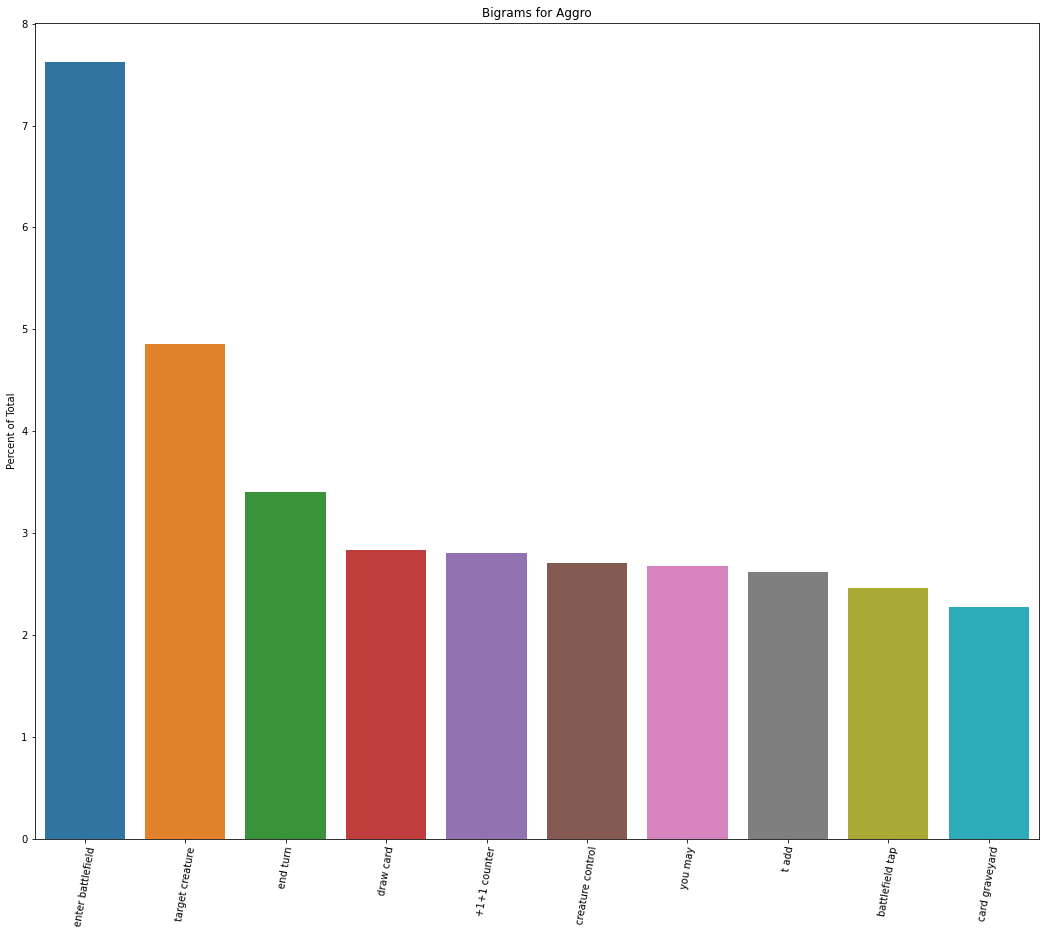

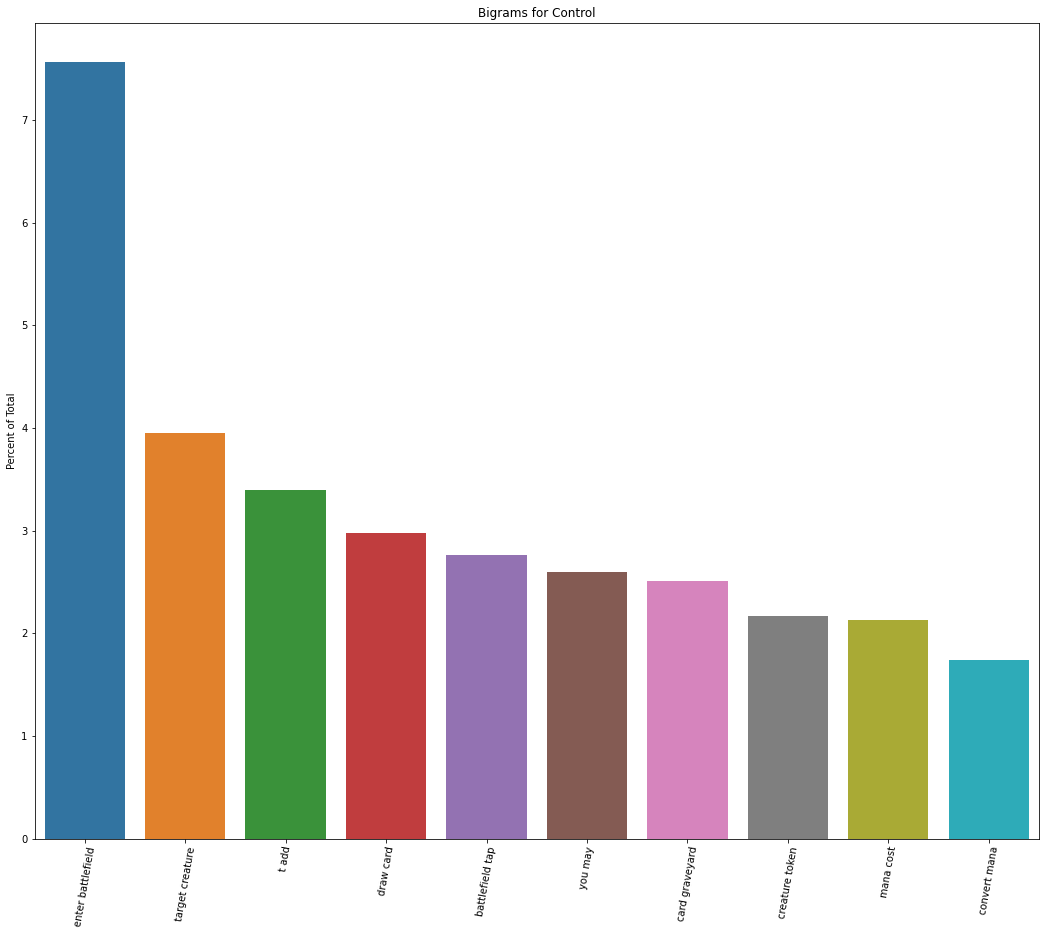

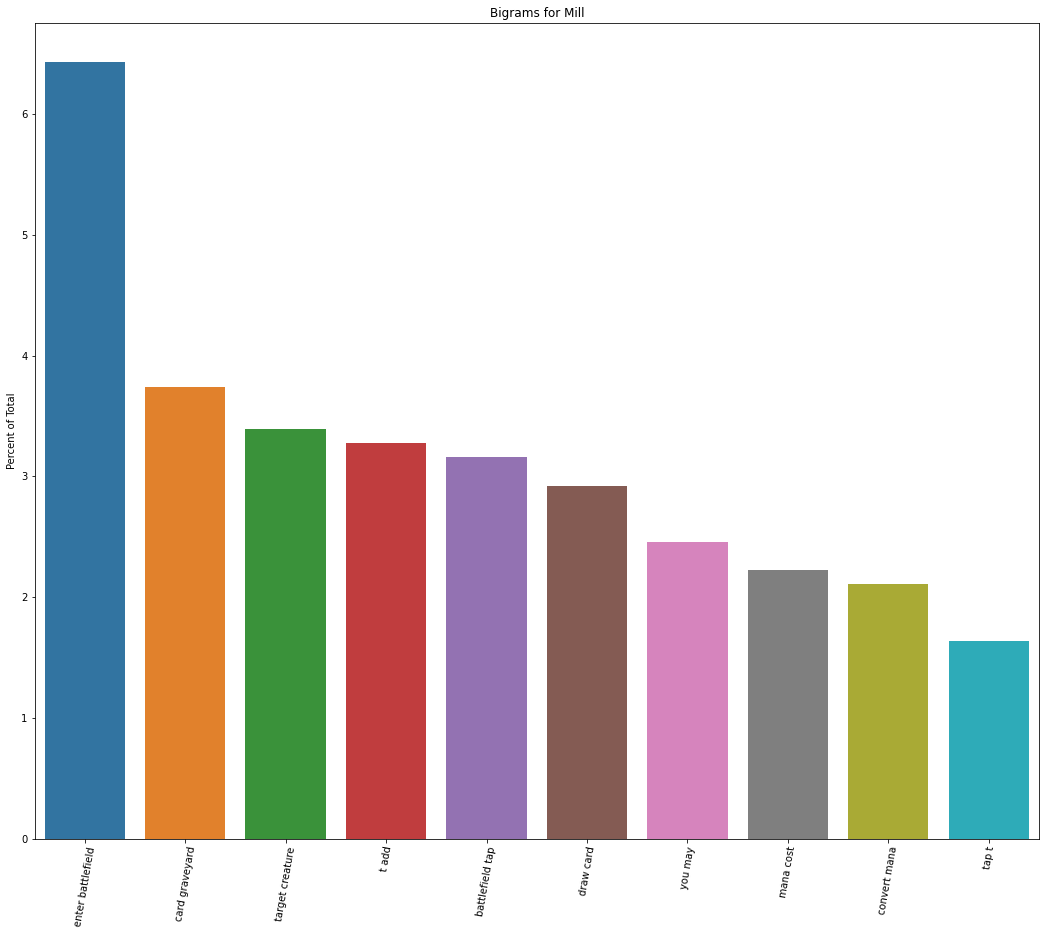

In [70]:
topn_analyze_card_text_by_archetype(main_decks, n=3, show=True)

In [71]:
oracle_texts[oracle_texts["oracle_text"].str.contains("\send\s.*\sturn[\s\.]", regex=True, flags=re.I)]

name  \
10        Kazandu Mammoth // Kazandu Valley   
33                      Brushfire Elemental   
59                         Crawling Barrens   
75                             Primal Might   
105          Rimrock Knight // Boulder Rush   
125                             Wicked Wolf   
163                    Kogla, the Titan Ape   
183                         Castle Embereth   
200                        Fervent Champion   
217                          Phoenix of Ash   
252                         Akoum Hellhound   
257                           Dream Trawler   
273                     Claim the Firstborn   
286                      Kargan Intimidator   
292                          Faceless Haven   
294                    Binding the Old Gods   
311                         Selfless Savior   
351                         Footfall Crater   
355                    Seasoned Hallowblade   
398                  Elspeth, Sun's Nemesis   
406                 Alseid of Life's Bounty   
419                               Soul Sear   
420                       Garruk, Unleashed   
483                     Immersturm Predator   
489                           Glory Bearers   
494                   Erebos's Intervention   
501                       Weaselback Redcap   
529                         Felidar Retreat   
531              Kenrith, the Returned King   
534                        The Royal Scions   
538                Winota, Joiner of Forces   
540                    Koma, Cosmos Serpent   
548                        Zulaport Duelist   
561                       Grasp of Darkness   
567                           Massacre Wurm   
597        Sejiri Shelter // Sejiri Glacier   
604   Faerie Guidemother // Gift of the Fae   
640                          Ranger's Guile   
664                Nissa of Shadowed Boughs   
667                               Infuriate   
671            Vito, Thorn of the Dusk Rose   
680                            Fight as One   
687                          Blizzard Brawl   
703                             Shadowspear   
707                         Arni Brokenbrow   
716                          Pestilent Haze   
719                          Snakeskin Veil   
763                      Blacklance Paragon   
765                     Firja's Retribution   
766                               Basri Ket   
772    Song-Mad Treachery // Song-Mad Ruins   
774                      Archpriest of Iona   
783                         Bronzehide Lion   
786                            Fearless Pup   
792                              Bolt Hound   
797                      Fearless Fledgling   
809       Makindi Stampede // Makindi Mesas   
826                        Wildwood Tracker   
842                    Reptilian Reflection   
854                           Crash Through   
887                  Watcher of the Spheres   
890                            Raking Claws   
905                         Master of Winds   
922                          Crippling Fear   
928             Beyeen Veil // Beyeen Coast   
935                      Almighty Brushwagg   
978                          Shadow Stinger   
983                     Heroic Intervention   
986                       Sea Gate Banneret   
990                             Grim Draugr   
998                        Stormwing Entity   
1021                          Discontinuity   
1024                        Goblin Wizardry   
1044                          Righteousness   
1050                             Riddleform   
1057                        Resolute Strike   
1062                      Witch's Vengeance   
1071                      Masked Blackguard   
1084                          Canopy Baloth   
1086                Akiri, Fearless Voyager   
1106                   Tentative Connection   
1123                 Eidolon of Inspiration   
1134                       Angel of Destiny   
1183                         Defiant Strike   
1197                       Daybreak Charger 

In [72]:
full_table_oracle_text = oracle_text_analysis(full_table)

In [73]:
full_table_oracle_text

name  \
6                                                Forest   
151                                            Mountain   
296                          Bonecrusher Giant // Stomp   
298                                 Brushfire Elemental   
300                                  Edgewall Innkeeper   
...                                                 ...   
1110624  Esika, God of the Tree // The Prismatic Bridge   
1113609                                     Frost Augur   
1113637                                Avalanche Caller   
1116525                                Ascendant Spirit   
1116527                                  Cosmos Charger   

                                                                                                                                                                                                                                                                                                                                                                                                     oracle_text  
6                                                                                                                                                                                                                                                                                                                                                                                                ({T}: Add {G}.)  
151                                                                                                                                                                                                                                                                                                                                                                                              ({T}: Add {R}.)  
296                                                                                                                                                                                                           Whenever Bonecrusher Giant becomes the target of a spell, Bonecrusher Giant deals 2 damage to that spell's controller. // Damage can't be prevented this turn. Stomp deals 2 damage to any target.  
298                                                                                                                                                                                                      Haste\nBrushfire Elemental can't be blocked by creatures with power 2 or less.\nLandfall — Whenever a land enters the battlefield under your control, Brushfire Elemental gets +2/+2 until end of turn.  
300                                                                                                                                                                                                                                                                                Whenever you cast a creature spell that has an Adventure, draw a card. (It doesn't need to have gone on the adventure first.)  
...                                                                                                                                                                                                                                                                                                                                                                                                          ...  
1110624                                  Vigilance\n{T}: Add one mana of any color.\nOther legendary creatures you control have vigilance and "{T}: Add one mana of any color." // At the beginning of your upkeep, reveal cards from the top of your library until you reveal a creature or planeswalker card. Put that card onto the battlefield and the rest on the bottom of your library in a random order.  
1113609                                                                                                               

In [74]:
make_ngram_df(full_table_oracle_text["oracle_text"], 2)

bigram  freq  pct_total
36        enter battlefield   386   6.952450
114         target creature   262   4.719020
42                 end turn   175   3.152017
83                  you may   159   2.863833
129            +1+1 counter   154   2.773775
49                draw card   153   2.755764
97         creature control   143   2.575648
0                     t add   130   2.341499
123          card graveyard   124   2.233429
63          battlefield tap   111   1.999280
78           creature token   108   1.945245
799              cast spell   100   1.801153
346               mana cost    97   1.747118
315            card library    80   1.440922
299        opponent control    77   1.386888
128                put +1+1    75   1.350865
84                 may cast    73   1.314841
360            discard card    71   1.278818
345            convert mana    69   1.242795
22            damage target    69   1.242795
229                at begin    66   1.188761
353          destroy target    65   1.170749
430          counter target    64   1.152738
910                two card    64   1.152738
115            creature get    58   1.044669
81               exile card    57   1.026657
267   creature planeswalker    57   1.026657
169                 may pay    56   1.008646
37      battlefield control    54   0.972622
313                look top    52   0.936599
308             deal damage    52   0.936599
126           creature card    51   0.918588
349        onto battlefield    49   0.882565
134                  1 life    46   0.828530
425               card hand    46   0.828530
393                 may put    45   0.810519
208                you gain    44   0.792507
762              choose one    44   0.792507
855             t sacrifice    43   0.774496
64                    tap t    43   0.774496
392             library you    43   0.774496
1338      whenever creature    42   0.756484
210                  2 life    42   0.756484
136             control get    42   0.756484
9              target spell    42   0.756484
396          bottom library    41   0.738473
341          search library    40   0.720461
171                  3 life    40   0.720461
44            whenever cast    39   0.702450
191                get +1+1    39   0.702450
574                put hand    38   0.684438
351         shuffle library    36   0.648415
27               cant block    36   0.648415
121            exile target    36   0.648415
484           return target    35   0.630403
314                top card    35   0.630403
45            cast creature    35   0.630403
843           damage player    34   0.612392
93            combat damage    34   0.612392
394                put card    34   0.612392
235               land card    33   0.594380
354         target artifact    33   0.594380
984         target opponent    32   0.576369
181               less cast    32   0.576369
127                card put    31   0.558357
2219                  pay 2    31   0.558357
361               card draw    31   0.558357
250              three card    31   0.558357
1165       activate ability    30   0.540346
1612             owner hand    30   0.540346
177              this spell    30   0.540346
133                  gain 1    30   0.540346
1966        instant sorcery    29   0.522334
1472       enchant creature    29   0.522334
141              one target    29   0.522334
1040                 gain 3    29   0.522334
1330      nonhuman creature    28   0.504323
168         battlefield may    28   0.504323
860           target player    28   0.504323
937      sacrifice creature    28   0.504323
82                 card you    28   0.504323
615       nonland permanent    27   0.486311
503              card exile    27   0.486311
256               cast card    27   0.486311
1003               x number    27   0.486311
74                create 11    27   0.486311
815                1 damage    26   0.468300
255           graveyard you    26   0.468300
102             

In [75]:
all_card_bigrams = make_ngram_df(card_table["oracle_text"], 2)

In [76]:
all_card_bigrams

bigram  freq  pct_total
3       enter battlefield  3094   5.699024
82        target creature  2732   5.032234
174              end turn  2373   4.370971
550                 t add  1725   3.177381
277      creature control  1453   2.676368
77           +1+1 counter  1308   2.409283
224             draw card  1172   2.158777
13                you may  1125   2.072205
34           creature get  1100   2.026156
72             cast spell  1013   1.865905
155        creature token   990   1.823540
239        card graveyard   944   1.738810
226              at begin   801   1.475410
300         damage target   773   1.423835
31       enchant creature   759   1.398048
208             mana cost   753   1.386996
46             cant block   698   1.285688
411       battlefield tap   678   1.248849
35               get +1+1   673   1.239639
652          discard card   669   1.232271
11           card library   630   1.160435
799         creature card   620   1.142015
342              put +1+1   603   1.110702
195        destroy target   595   1.095966
44          this creature   581   1.070179
87               may cast   559   1.029656
49            deal damage   555   1.022288
626         combat damage   550   1.013078
205      opponent control   524   0.965187
380        counter target   506   0.932032
546         target player   499   0.919138
145           control get   495   0.911770
45          creature cant   491   0.904402
33     enchanted creature   486   0.895192
281                1 life   483   0.889667
1036       search library   480   0.884141
227          begin upkeep   471   0.867563
4     battlefield control   455   0.838092
1039      shuffle library   441   0.812304
207          convert mana   437   0.804936
1574              may pay   434   0.799411
1355     onto battlefield   421   0.775465
147         whenever cast   418   0.769939
801     whenever creature   416   0.766255
495             card hand   412   0.758887
854         damage player   408   0.751520
459              two card   400   0.736784
321            owner hand   394   0.725732
355          first strike   380   0.699945
318         return target   376   0.692577
392     artifact creature   370   0.681525
1005             1 damage   368   0.677841
32     creature enchanted   360   0.663106
369      activate ability   357   0.657580
625           deal combat   355   0.653896
8                look top   349   0.642844
373       target artifact   336   0.618899
425          target spell   336   0.618899
605              put card   335   0.617057
993              card put   335   0.617057
350              get +2+2   328   0.604163
603              top card   327   0.602321
1017      battlefield may   319   0.587585
103           t sacrifice   317   0.583901
1004               deal 1   317   0.583901
761        graveyard hand   311   0.572850
113        block creature   310   0.571008
1728                add g   307   0.565482
810                2 life   307   0.565482
877         creature deal   307   0.565482
401          creature fly   307   0.565482
85             exile card   304   0.559956
844    sacrifice creature   304   0.559956
1020             2 damage   302   0.556272
604               may put   301   0.554430
383             create 11   297   0.547062
627       damage creature   295   0.543378
773              get +1+0   295   0.543378
106              you gain   294   0.541536
23               put hand   294   0.541536
27         bottom library   292   0.537852
1435             one mana   292   0.537852
1353            land card   285   0.524959
831       target opponent   285   0.524959
2037                add r   280   0.515749
1019               deal 2   278   0.512065
927            would deal   270   0.497329
2057                add b   270   0.497329
363              +1+1 end   269   0.495487
134              end step   269   0.495487
551                 add u   267   0.491803
280                gain 1   265   0.488119
2029                

In [77]:
tstat, pval = ttest_1samp(bigrams["freq"], np.mean(all_card_bigrams["freq"]))

In [78]:
pval

8.715421658743445e-113

In [79]:
def save_to_pdf():
    with PdfPages("MTG Viz.pdf") as pdf:
        most_winning_archetypes()
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors_by_set(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        topn_colors_archetypes(first_place_decks, n=3, pdf=pdf)
        plt.close("all")
        
        most_used_cards_graphics(main_decks)
        pdf.savefig()
        plt.close("all")
        
        topn_archetypes(main_decks, n=3, pdf=pdf)
        plt.close("all")
        
        topn_categories(main_decks, n=3, pdf=pdf)
        plt.close("all")
        
        cards_by_set(main_decks)
        pdf.savefig()
        plt.close("all")
        
        cards_by_set(main_decks, unique_cards=True)
        pdf.savefig()
        plt.close("all")
        
        number_of_decks_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        categories_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        archetypes_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        plot_color_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        plot_set_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        topn_analyze_card_text_by_archetype(main_decks, n=3, pdf=pdf)
        plt.close("all")

In [80]:
save_to_pdf()

In [81]:
full_table[full_table["eventId"] == full_table["eventId"].max()]

eventId                                        name_event       date  \
84070      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84071      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84072      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84073      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84074      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84075      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84076      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84077      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84078      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84079      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84080      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84081      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84082      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84083      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84084      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84085      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84086      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84087      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84088      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84089      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84090      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84091      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84092      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84093      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84094      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84095      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84096      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84097      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84098      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84099      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84100      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84101      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84102      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84103      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84104      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84105      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84106      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84107      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84108      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84109      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84110      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84111      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84112      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84113      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84114      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84115      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84116      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84117      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84118      599  United Valentine Invitational @ F2K (Fade2Karma) 2021-02-13   
84119      599  United Valentine Invitational @ F2K (Fade